In [1]:
import sys
sys.path.append('..')

import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import gaussian, threshold_otsu
from skimage.transform import resize
from skimage import io
import pickle
from skimage.measure import regionprops

import matplotlib.pyplot as plt
import torch
import time
import model.model_cnnvae_conditional
import model.optimizer as optimizer
from sklearn.decomposition import PCA
import pandas as pd
from model.model_cnnvae import FC_l2

In [2]:
prevSampled=0
nSamples=36
holdOutSamples_samples=[['HV1','P22','P14','P27','HV3','P46','P24','P37'],
                        ['HV5','P68','P44','P42','HV7','P15','P55','P59'],
                        ['HV8','P47','P63','P70','HV2','P57','P72','P83'],
                        ['HV4','P16','P18','P62','HV6','P52','P41','P38'],
                        ['HV1','P84','P50','P48','HV2','P22','P56','P27'],
                        ['HV3','P46','P14','P37','HV4','P68','P44','P42'],
                        ['HV5','P15','P24','P59','HV6','P47','P55','P70'],
                        ['HV7','P57','P63','P83','HV8','P16','P18','P62'],
                        ['HV1','P52','P72','P38','HV5','P84','P41','P48'],
                        ['HV2','P22','P50','P27','HV3','P68','P24','P59'],
                        ['HV4','P47','P56','P37','HV7','P16','P44','P70'],
                        ['HV6','P46','P14','P42','HV8','P15','P55','P83']]

In [3]:
sourceDir='/data/xinyi/c2p/data/chromark'
segDir=os.path.join(sourceDir,'nuclear_masks')
imgDir=os.path.join(sourceDir,'raw_data')
conditions=['controls','headneck','meningioma', 'glioma']

outSize=128
savename='pathCentered_'+str(outSize)


In [4]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [5]:
seed=3
epochs=2001
saveFreq=25
lr=0.0001
weight_decay=0 #Weight for L2 loss on embedding matrix.

batchsize=256
valRatio=0.2

In [6]:
def train(epoch,model_clf,optimizer_clf,inputImgs,inputImgs_val,labels_train,labels_val):
    np.random.seed(3)
    train_nodes_idx=np.arange(labels_train.size()[0])
    val_nodes_idx=np.arange(labels_val.size()[0])
    np.random.shuffle(train_nodes_idx)
    t = time.time()
    model_clf.train()
    loss_all=0
    
    ntrainBatches=int(np.ceil(train_nodes_idx.shape[0]/batchsize))
    for i in range(ntrainBatches):
#         if i%200==0:
#             print(i)
        trainIdx=train_nodes_idx[i*batchsize:min((i+1)*batchsize,train_nodes_idx.shape[0])]
        train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
        trainInput=torch.tensor(inputImgs[trainIdx]).cuda().float()

        optimizer_clf.zero_grad()

        pred = model_clf(trainInput)

        loss=loss_clf(pred, train_labels)
        loss_all+=loss.item()
            
        loss.backward()
        optimizer_clf.step()

    loss_all=loss_all/ntrainBatches
    
    with torch.no_grad():
        model_clf.eval()
        loss_val_all=0
        nvalBatches=int(np.ceil(val_nodes_idx.shape[0]/batchsize))
        for i in range(nvalBatches):
            valIdx=val_nodes_idx[i*batchsize:min((i+1)*batchsize,val_nodes_idx.shape[0])]
            val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
            valInput=torch.tensor(inputImgs_val[valIdx]).cuda().float()


            pred = model_clf(valInput)

            loss=loss_clf(pred, val_labels)
            loss_val_all+=loss.item()

        loss_val_all=loss_val_all/nvalBatches
    if epoch%10==0:
        print(' Epoch: {:04d}'.format(epoch),
              'loss_train: {:.4f}'.format(loss_all),
              'loss_val: {:.4f}'.format(loss_val_all),
              'time: {:.4f}s'.format(time.time() - t))
    return loss_all,loss_val_all







In [7]:
name_train='conditionClf_nmco_sampling_featureAblation'
modelname_train='nmco2cond_fc_l2'
logsavepath_train=os.path.join('/data/xinyi/c2p/log/',modelname_train,name_train)
modelsavepath_train=os.path.join('/data/xinyi/c2p/models/',modelname_train,name_train)
plotsavepath_train=os.path.join('/data/xinyi/c2p/plots/',modelname_train,name_train)

if not os.path.exists(os.path.join('/data/xinyi/c2p/log/',modelname_train)):
    os.mkdir(os.path.join('/data/xinyi/c2p/log/',modelname_train))
    os.mkdir(os.path.join('/data/xinyi/c2p/models/',modelname_train))
    os.mkdir(os.path.join('/data/xinyi/c2p/plots/',modelname_train))
if not os.path.exists(logsavepath_train):
    os.mkdir(logsavepath_train)
if not os.path.exists(modelsavepath_train):
    os.mkdir(modelsavepath_train)
if not os.path.exists(plotsavepath_train):
    os.mkdir(plotsavepath_train)

gh2ax
gh2ax_foci_count
0
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
hold out: HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
0


/tmp/ipykernel_1906045/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1906045/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 112.1321 loss_val: 77.3308 time: 0.7830s
 Epoch: 0010 loss_train: 27.8051 loss_val: 17.1908 time: 0.0541s
 Epoch: 0020 loss_train: 16.5006 loss_val: 9.1532 time: 0.0500s
 Epoch: 0030 loss_train: 11.4976 loss_val: 5.3529 time: 0.0657s
 Epoch: 0040 loss_train: 7.5931 loss_val: 3.2545 time: 0.0495s
 Epoch: 0050 loss_train: 5.7463 loss_val: 2.1910 time: 0.0513s
 Epoch: 0060 loss_train: 4.1539 loss_val: 1.8193 time: 0.0476s
 Epoch: 0070 loss_train: 3.5009 loss_val: 1.5470 time: 0.0592s
 Epoch: 0080 loss_train: 2.9418 loss_val: 1.4779 time: 0.0563s
 Epoch: 0090 loss_train: 2.5971 loss_val: 1.4919 time: 0.0453s
 Epoch: 0100 loss_train: 2.3085 loss_val: 1.3345 time: 0.0578s
 Epoch: 0110 loss_train: 1.7868 loss_val: 1.2880 time: 0.0534s
 Epoch: 0120 loss_train: 1.8070 loss_val: 1.2256 time: 0.0518s
 Epoch: 0130 loss_train: 1.7536 loss_val: 1.2167 time: 0.0461s
 Epoch: 0140 loss_train: 1.5478 loss_val: 1.1741 time: 0.0546s
 Epoch: 0150 loss_train: 1.3825 loss_val: 1.0511

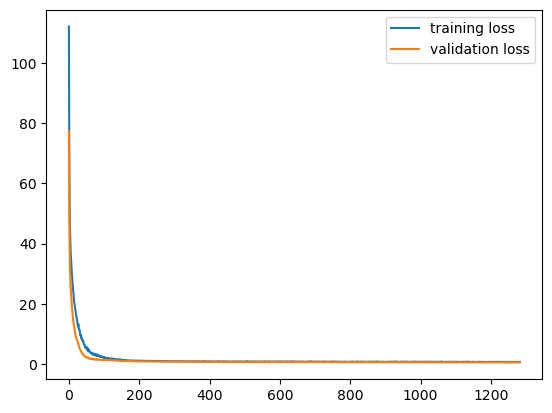

1
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
hold out: P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
hold out: P59
P38
P48
P37
P62
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
hold out: P68
1
 Epoch: 0000 loss_train: 107.9405 loss_val: 66.8240 time: 0.0574s


/tmp/ipykernel_1906045/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1906045/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 27.1119 loss_val: 14.4910 time: 0.0460s
 Epoch: 0020 loss_train: 16.8672 loss_val: 7.7987 time: 0.0447s
 Epoch: 0030 loss_train: 12.0361 loss_val: 5.2990 time: 0.0502s
 Epoch: 0040 loss_train: 8.3964 loss_val: 3.4475 time: 0.0478s
 Epoch: 0050 loss_train: 4.9945 loss_val: 2.6126 time: 0.0527s
 Epoch: 0060 loss_train: 4.1937 loss_val: 2.2518 time: 0.0497s
 Epoch: 0070 loss_train: 3.1702 loss_val: 1.9813 time: 0.0483s
 Epoch: 0080 loss_train: 2.7785 loss_val: 1.8049 time: 0.0558s
 Epoch: 0090 loss_train: 2.5004 loss_val: 1.6760 time: 0.0463s
 Epoch: 0100 loss_train: 2.3654 loss_val: 1.5732 time: 0.0464s
 Epoch: 0110 loss_train: 1.9388 loss_val: 1.4563 time: 0.0514s
 Epoch: 0120 loss_train: 1.8238 loss_val: 1.3234 time: 0.0496s
 Epoch: 0130 loss_train: 1.7093 loss_val: 1.2686 time: 0.0601s
 Epoch: 0140 loss_train: 1.5579 loss_val: 1.1683 time: 0.0453s
 Epoch: 0150 loss_train: 1.4320 loss_val: 1.0778 time: 0.0476s
 Epoch: 0160 loss_train: 1.2974 loss_val: 1.0186 ti

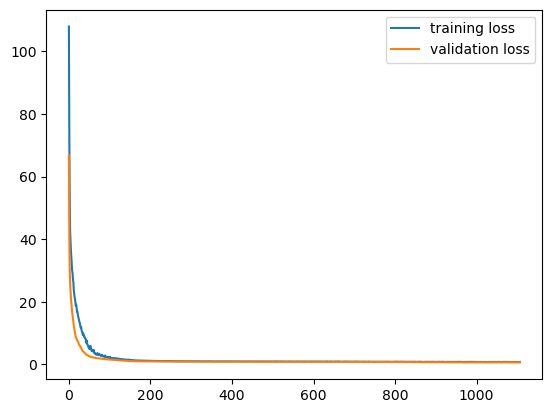

2
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
hold out: P83
P42
P59
P38
P48
P37
P62
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
hold out: P57
P15
P29
img not found P29
P68
2
 Epoch: 0000 loss_train: 104.6422 loss_val: 61.9575 time: 0.0587s


/tmp/ipykernel_1906045/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1906045/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 26.8713 loss_val: 13.9606 time: 0.0497s
 Epoch: 0020 loss_train: 16.3173 loss_val: 7.0570 time: 0.0655s
 Epoch: 0030 loss_train: 12.3242 loss_val: 4.8513 time: 0.0645s
 Epoch: 0040 loss_train: 7.3462 loss_val: 2.9286 time: 0.0542s
 Epoch: 0050 loss_train: 5.2603 loss_val: 2.3322 time: 0.0620s
 Epoch: 0060 loss_train: 4.1568 loss_val: 2.0618 time: 0.0534s
 Epoch: 0070 loss_train: 3.2359 loss_val: 1.7677 time: 0.0569s
 Epoch: 0080 loss_train: 2.4759 loss_val: 1.6641 time: 0.0508s
 Epoch: 0090 loss_train: 2.4682 loss_val: 1.4882 time: 0.0597s
 Epoch: 0100 loss_train: 2.0869 loss_val: 1.3101 time: 0.0500s
 Epoch: 0110 loss_train: 1.8614 loss_val: 1.1884 time: 0.0504s
 Epoch: 0120 loss_train: 1.8357 loss_val: 1.1083 time: 0.0525s
 Epoch: 0130 loss_train: 1.6189 loss_val: 1.0562 time: 0.0622s
 Epoch: 0140 loss_train: 1.4261 loss_val: 1.0138 time: 0.0740s
 Epoch: 0150 loss_train: 1.3546 loss_val: 0.9895 time: 0.0484s
 Epoch: 0160 loss_train: 1.2565 loss_val: 0.9624 ti

 Epoch: 1310 loss_train: 0.7467 loss_val: 0.5972 time: 0.0470s
 Epoch: 1320 loss_train: 0.7303 loss_val: 0.5961 time: 0.0536s
 Epoch: 1330 loss_train: 0.7626 loss_val: 0.6002 time: 0.0489s
 Epoch: 1340 loss_train: 0.7263 loss_val: 0.5951 time: 0.0510s
 Epoch: 1350 loss_train: 0.7452 loss_val: 0.5910 time: 0.0509s
 Epoch: 1360 loss_train: 0.7389 loss_val: 0.5907 time: 0.0506s
 Epoch: 1370 loss_train: 0.7162 loss_val: 0.5898 time: 0.0476s
 Epoch: 1380 loss_train: 0.7426 loss_val: 0.5938 time: 0.0483s
 Epoch: 1390 loss_train: 0.7179 loss_val: 0.5870 time: 0.0488s
 Epoch: 1400 loss_train: 0.7270 loss_val: 0.5862 time: 0.0484s
 Epoch: 1410 loss_train: 0.7364 loss_val: 0.5870 time: 0.0578s
 Epoch: 1420 loss_train: 0.7246 loss_val: 0.5876 time: 0.0471s
 Epoch: 1430 loss_train: 0.7383 loss_val: 0.5861 time: 0.0460s
 Epoch: 1440 loss_train: 0.7142 loss_val: 0.5837 time: 0.0555s
 Epoch: 1450 loss_train: 0.7243 loss_val: 0.5807 time: 0.0549s
 Epoch: 1460 loss_train: 0.7244 loss_val: 0.5799 time: 

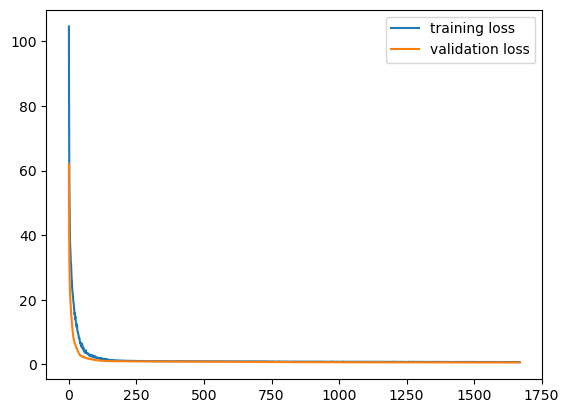

3
controls
dapi_gh2ax_lamin
HV5
hold out: HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
hold out: HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
hold out: P41
P56
hold out: P18
P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
hold out: P38
P48
P37
hold out: P62
glioma
dapi_gh2ax_lamin_cd3
P46
hold out: P16
hold out: P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
3
 Epoch: 0000 loss_train: 104.4156 loss_val: 68.9717 time: 0.0457s


/tmp/ipykernel_1906045/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1906045/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 27.3056 loss_val: 14.3342 time: 0.0434s
 Epoch: 0020 loss_train: 16.5765 loss_val: 7.2182 time: 0.0438s
 Epoch: 0030 loss_train: 10.9844 loss_val: 4.7780 time: 0.0495s
 Epoch: 0040 loss_train: 7.5622 loss_val: 3.2362 time: 0.0503s
 Epoch: 0050 loss_train: 5.2015 loss_val: 2.1713 time: 0.0506s
 Epoch: 0060 loss_train: 3.9131 loss_val: 1.7274 time: 0.0501s
 Epoch: 0070 loss_train: 3.1884 loss_val: 1.5852 time: 0.0584s
 Epoch: 0080 loss_train: 2.5012 loss_val: 1.4503 time: 0.0496s
 Epoch: 0090 loss_train: 2.1189 loss_val: 1.3802 time: 0.0555s
 Epoch: 0100 loss_train: 2.0122 loss_val: 1.2622 time: 0.0451s
 Epoch: 0110 loss_train: 1.6873 loss_val: 1.2134 time: 0.0518s
 Epoch: 0120 loss_train: 1.5838 loss_val: 1.1337 time: 0.0456s
 Epoch: 0130 loss_train: 1.5170 loss_val: 1.0930 time: 0.0482s
 Epoch: 0140 loss_train: 1.4383 loss_val: 1.0576 time: 0.0434s
 Epoch: 0150 loss_train: 1.3151 loss_val: 1.0060 time: 0.0525s
 Epoch: 0160 loss_train: 1.2258 loss_val: 0.9760 ti

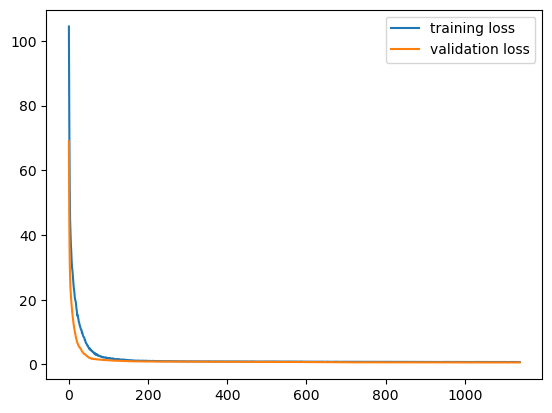

4
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
hold out: P56
P18
P55
hold out: P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
hold out: P48
P37
P62
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
hold out: P84
P47
P57
P15
P29
img not found P29
P68
4
 Epoch: 0000 loss_train: 104.6770 loss_val: 72.2510 time: 0.0459s


/tmp/ipykernel_1906045/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1906045/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 27.6440 loss_val: 16.3811 time: 0.0538s
 Epoch: 0020 loss_train: 17.2988 loss_val: 9.4057 time: 0.0445s
 Epoch: 0030 loss_train: 11.6101 loss_val: 5.6905 time: 0.0558s
 Epoch: 0040 loss_train: 7.8971 loss_val: 3.5855 time: 0.0474s
 Epoch: 0050 loss_train: 6.0062 loss_val: 2.4761 time: 0.0476s
 Epoch: 0060 loss_train: 4.4993 loss_val: 1.8156 time: 0.0630s
 Epoch: 0070 loss_train: 3.5626 loss_val: 1.6686 time: 0.0464s
 Epoch: 0080 loss_train: 2.8195 loss_val: 1.4465 time: 0.0450s
 Epoch: 0090 loss_train: 2.4634 loss_val: 1.4033 time: 0.0467s
 Epoch: 0100 loss_train: 2.2187 loss_val: 1.2878 time: 0.0575s
 Epoch: 0110 loss_train: 1.9060 loss_val: 1.2026 time: 0.0462s
 Epoch: 0120 loss_train: 1.8511 loss_val: 1.1612 time: 0.0482s
 Epoch: 0130 loss_train: 1.5676 loss_val: 1.1324 time: 0.0490s
 Epoch: 0140 loss_train: 1.4805 loss_val: 1.0858 time: 0.0483s
 Epoch: 0150 loss_train: 1.3810 loss_val: 1.0476 time: 0.0532s
 Epoch: 0160 loss_train: 1.2429 loss_val: 1.0179 ti

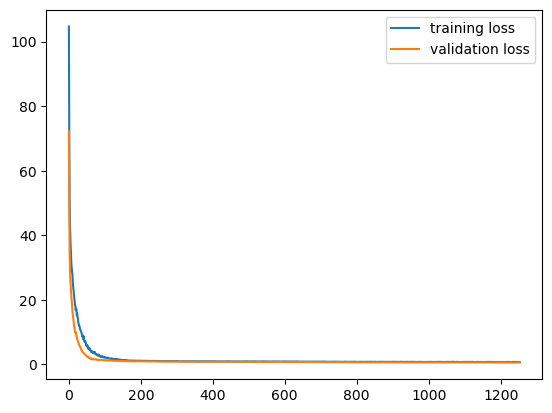

5
controls
dapi_gh2ax_lamin
HV5
hold out: HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
hold out: P44
P41
P56
P18
P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
hold out: P37
P62
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
5
 Epoch: 0000 loss_train: 108.5417 loss_val: 66.7904 time: 0.0551s


/tmp/ipykernel_1906045/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1906045/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 26.6026 loss_val: 14.5214 time: 0.0502s
 Epoch: 0020 loss_train: 15.9856 loss_val: 7.7413 time: 0.0709s
 Epoch: 0030 loss_train: 10.9580 loss_val: 5.2051 time: 0.0575s
 Epoch: 0040 loss_train: 8.7249 loss_val: 3.7859 time: 0.0574s
 Epoch: 0050 loss_train: 5.5614 loss_val: 2.7832 time: 0.0646s
 Epoch: 0060 loss_train: 4.3319 loss_val: 2.3212 time: 0.0493s
 Epoch: 0070 loss_train: 4.3716 loss_val: 2.0714 time: 0.0475s
 Epoch: 0080 loss_train: 2.9995 loss_val: 1.9784 time: 0.0522s
 Epoch: 0090 loss_train: 2.6692 loss_val: 1.8695 time: 0.0504s
 Epoch: 0100 loss_train: 2.6316 loss_val: 1.6740 time: 0.0480s
 Epoch: 0110 loss_train: 2.0818 loss_val: 1.5706 time: 0.0664s
 Epoch: 0120 loss_train: 1.7532 loss_val: 1.4567 time: 0.0542s
 Epoch: 0130 loss_train: 1.6791 loss_val: 1.4875 time: 0.0470s
 Epoch: 0140 loss_train: 1.4981 loss_val: 1.4197 time: 0.0556s
 Epoch: 0150 loss_train: 1.3146 loss_val: 1.3608 time: 0.0525s
 Epoch: 0160 loss_train: 1.3017 loss_val: 1.3624 ti

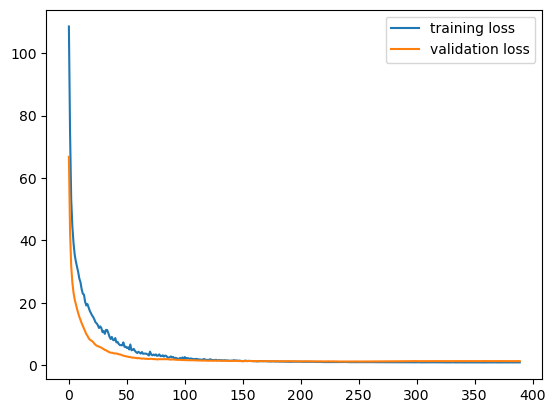

6
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
hold out: HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
6
 Epoch: 0000 loss_train: 112.8310 loss_val: 69.6200 time: 0.0558s


/tmp/ipykernel_1906045/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1906045/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 28.5071 loss_val: 14.1497 time: 0.0633s
 Epoch: 0020 loss_train: 17.0623 loss_val: 7.3279 time: 0.0486s
 Epoch: 0030 loss_train: 12.1821 loss_val: 4.5270 time: 0.0491s
 Epoch: 0040 loss_train: 8.5633 loss_val: 3.0122 time: 0.0719s
 Epoch: 0050 loss_train: 6.5564 loss_val: 2.0582 time: 0.0535s
 Epoch: 0060 loss_train: 4.2323 loss_val: 1.7220 time: 0.0567s
 Epoch: 0070 loss_train: 3.5898 loss_val: 1.5380 time: 0.0533s
 Epoch: 0080 loss_train: 2.6196 loss_val: 1.4792 time: 0.0611s
 Epoch: 0090 loss_train: 2.6727 loss_val: 1.4249 time: 0.0613s
 Epoch: 0100 loss_train: 2.3158 loss_val: 1.2788 time: 0.0446s
 Epoch: 0110 loss_train: 2.0386 loss_val: 1.1963 time: 0.0568s
 Epoch: 0120 loss_train: 1.7760 loss_val: 1.1531 time: 0.0469s
 Epoch: 0130 loss_train: 1.7137 loss_val: 1.1106 time: 0.0545s
 Epoch: 0140 loss_train: 1.5634 loss_val: 1.0721 time: 0.0673s
 Epoch: 0150 loss_train: 1.5252 loss_val: 1.0192 time: 0.0602s
 Epoch: 0160 loss_train: 1.3555 loss_val: 0.9621 ti

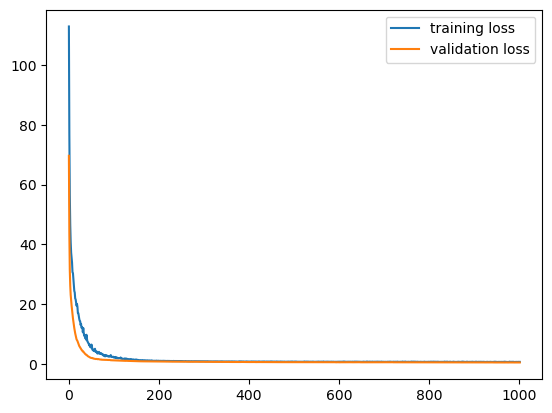

7
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
hold out: P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
hold out: P59
P38
P48
P37
P62
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
hold out: P68
7
 Epoch: 0000 loss_train: 108.3909 loss_val: 69.8550 time: 0.0636s


/tmp/ipykernel_1906045/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1906045/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 27.1514 loss_val: 17.2354 time: 0.0657s
 Epoch: 0020 loss_train: 16.3296 loss_val: 9.4169 time: 0.0564s
 Epoch: 0030 loss_train: 11.6342 loss_val: 6.0141 time: 0.0533s
 Epoch: 0040 loss_train: 7.6728 loss_val: 3.7945 time: 0.0467s
 Epoch: 0050 loss_train: 6.3671 loss_val: 2.4922 time: 0.0495s
 Epoch: 0060 loss_train: 3.9075 loss_val: 2.1350 time: 0.0640s
 Epoch: 0070 loss_train: 3.2591 loss_val: 1.8119 time: 0.0626s
 Epoch: 0080 loss_train: 2.5877 loss_val: 1.5993 time: 0.0471s
 Epoch: 0090 loss_train: 2.5307 loss_val: 1.5600 time: 0.0466s
 Epoch: 0100 loss_train: 2.1239 loss_val: 1.4446 time: 0.0484s
 Epoch: 0110 loss_train: 1.8883 loss_val: 1.4028 time: 0.0504s
 Epoch: 0120 loss_train: 1.7894 loss_val: 1.3286 time: 0.0603s
 Epoch: 0130 loss_train: 1.6222 loss_val: 1.2372 time: 0.0620s
 Epoch: 0140 loss_train: 1.5298 loss_val: 1.1663 time: 0.0619s
 Epoch: 0150 loss_train: 1.4128 loss_val: 1.1239 time: 0.0482s
 Epoch: 0160 loss_train: 1.3208 loss_val: 1.0475 ti

 Epoch: 1310 loss_train: 0.7723 loss_val: 0.6394 time: 0.0452s
 Epoch: 1320 loss_train: 0.7632 loss_val: 0.6324 time: 0.0571s
 Epoch: 1330 loss_train: 0.7966 loss_val: 0.6311 time: 0.0509s
 Epoch: 1340 loss_train: 0.7750 loss_val: 0.6329 time: 0.0560s
 Epoch: 1350 loss_train: 0.7783 loss_val: 0.6348 time: 0.0465s
 Epoch: 1360 loss_train: 0.7821 loss_val: 0.6275 time: 0.0454s
 Epoch: 1370 loss_train: 0.7571 loss_val: 0.6372 time: 0.0545s
 Epoch: 1380 loss_train: 0.7632 loss_val: 0.6280 time: 0.0569s
 Epoch: 1390 loss_train: 0.7571 loss_val: 0.6262 time: 0.0472s
 Epoch: 1400 loss_train: 0.7630 loss_val: 0.6262 time: 0.0473s
 Epoch: 1410 loss_train: 0.7757 loss_val: 0.6311 time: 0.0459s
 Epoch: 1420 loss_train: 0.7537 loss_val: 0.6319 time: 0.0435s
 Epoch: 1430 loss_train: 0.7504 loss_val: 0.6297 time: 0.0441s
 Epoch: 1440 loss_train: 0.7543 loss_val: 0.6353 time: 0.0476s
 Epoch: 1450 loss_train: 0.7549 loss_val: 0.6303 time: 0.0681s
 Epoch: 1460 loss_train: 0.7554 loss_val: 0.6283 time: 

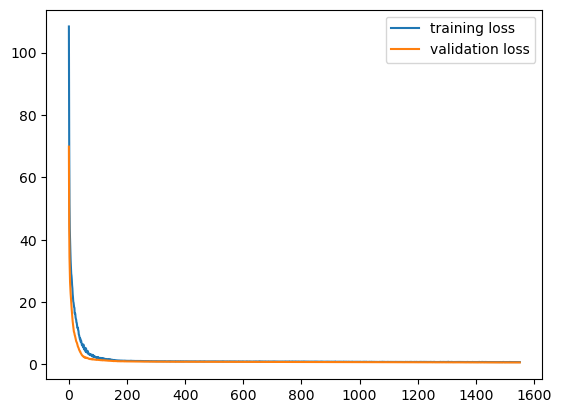

8
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
hold out: P83
P42
P59
P38
P48
P37
P62
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
hold out: P57
P15
P29
img not found P29
P68
8
 Epoch: 0000 loss_train: 104.0241 loss_val: 68.2631 time: 0.0506s


/tmp/ipykernel_1906045/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1906045/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 26.1164 loss_val: 15.9072 time: 0.0540s
 Epoch: 0020 loss_train: 15.2306 loss_val: 8.7415 time: 0.0475s
 Epoch: 0030 loss_train: 10.4413 loss_val: 5.3868 time: 0.0491s
 Epoch: 0040 loss_train: 7.6580 loss_val: 4.1719 time: 0.0514s
 Epoch: 0050 loss_train: 5.4557 loss_val: 3.5317 time: 0.0636s
 Epoch: 0060 loss_train: 4.0517 loss_val: 2.9460 time: 0.0577s
 Epoch: 0070 loss_train: 3.2136 loss_val: 2.6219 time: 0.0618s
 Epoch: 0080 loss_train: 2.8017 loss_val: 2.4184 time: 0.0474s
 Epoch: 0090 loss_train: 2.4650 loss_val: 2.1324 time: 0.0473s
 Epoch: 0100 loss_train: 2.0697 loss_val: 1.8633 time: 0.0480s
 Epoch: 0110 loss_train: 1.8786 loss_val: 1.6293 time: 0.0484s
 Epoch: 0120 loss_train: 1.7458 loss_val: 1.4929 time: 0.0519s
 Epoch: 0130 loss_train: 1.6147 loss_val: 1.3646 time: 0.0540s
 Epoch: 0140 loss_train: 1.3875 loss_val: 1.2556 time: 0.0676s
 Epoch: 0150 loss_train: 1.3118 loss_val: 1.2146 time: 0.0461s
 Epoch: 0160 loss_train: 1.3083 loss_val: 1.2048 ti

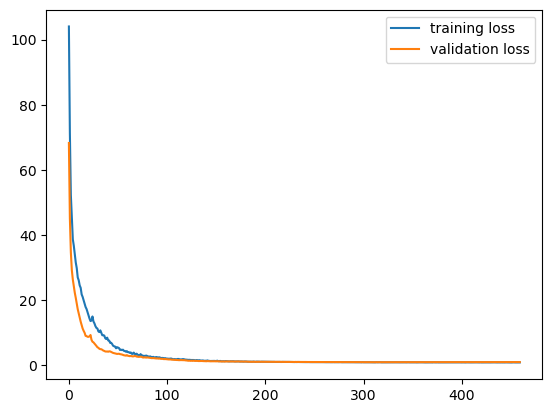

9
controls
dapi_gh2ax_lamin
HV5
hold out: HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
hold out: HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
hold out: P41
P56
hold out: P18
P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
hold out: P38
P48
P37
hold out: P62
glioma
dapi_gh2ax_lamin_cd3
P46
hold out: P16
hold out: P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
9
 Epoch: 0000 loss_train: 102.6613 loss_val: 65.4013 time: 0.0518s


/tmp/ipykernel_1906045/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1906045/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 26.8707 loss_val: 17.2158 time: 0.0594s
 Epoch: 0020 loss_train: 15.8981 loss_val: 9.1553 time: 0.0592s
 Epoch: 0030 loss_train: 11.3697 loss_val: 5.9818 time: 0.0522s
 Epoch: 0040 loss_train: 7.5357 loss_val: 3.9516 time: 0.0480s
 Epoch: 0050 loss_train: 5.1507 loss_val: 2.7084 time: 0.0457s
 Epoch: 0060 loss_train: 3.4921 loss_val: 2.2174 time: 0.0749s
 Epoch: 0070 loss_train: 2.7721 loss_val: 1.9618 time: 0.0488s
 Epoch: 0080 loss_train: 2.2622 loss_val: 1.8329 time: 0.0592s
 Epoch: 0090 loss_train: 2.1115 loss_val: 1.6594 time: 0.0462s
 Epoch: 0100 loss_train: 1.8868 loss_val: 1.5068 time: 0.0518s
 Epoch: 0110 loss_train: 1.6383 loss_val: 1.4373 time: 0.0596s
 Epoch: 0120 loss_train: 1.6089 loss_val: 1.3346 time: 0.0612s
 Epoch: 0130 loss_train: 1.4615 loss_val: 1.2356 time: 0.0524s
 Epoch: 0140 loss_train: 1.3973 loss_val: 1.1728 time: 0.0586s
 Epoch: 0150 loss_train: 1.3128 loss_val: 1.1088 time: 0.0460s
 Epoch: 0160 loss_train: 1.2174 loss_val: 1.0708 ti

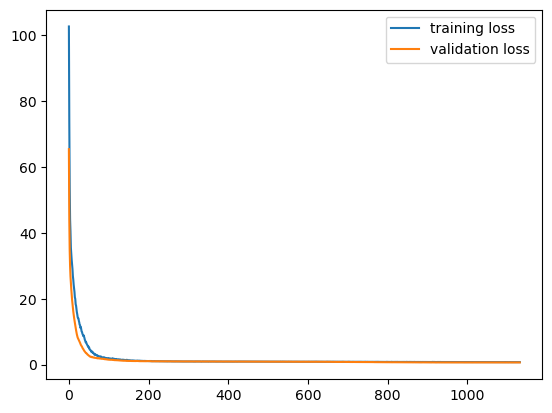

10
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
hold out: P56
P18
P55
hold out: P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
hold out: P48
P37
P62
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
hold out: P84
P47
P57
P15
P29
img not found P29
P68
10
 Epoch: 0000 loss_train: 102.7559 loss_val: 67.8224 time: 0.0476s


/tmp/ipykernel_1906045/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1906045/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 26.7221 loss_val: 14.4565 time: 0.0645s
 Epoch: 0020 loss_train: 17.0977 loss_val: 7.7345 time: 0.0765s
 Epoch: 0030 loss_train: 11.4592 loss_val: 5.0944 time: 0.0563s
 Epoch: 0040 loss_train: 7.8948 loss_val: 3.2996 time: 0.0565s
 Epoch: 0050 loss_train: 5.5182 loss_val: 2.4588 time: 0.0515s
 Epoch: 0060 loss_train: 4.1007 loss_val: 1.7823 time: 0.0588s
 Epoch: 0070 loss_train: 3.6042 loss_val: 1.6196 time: 0.0637s
 Epoch: 0080 loss_train: 3.0511 loss_val: 1.4599 time: 0.0625s
 Epoch: 0090 loss_train: 2.6927 loss_val: 1.4181 time: 0.0541s
 Epoch: 0100 loss_train: 2.3086 loss_val: 1.3141 time: 0.0446s
 Epoch: 0110 loss_train: 2.1210 loss_val: 1.2387 time: 0.0597s
 Epoch: 0120 loss_train: 1.8151 loss_val: 1.1992 time: 0.0450s
 Epoch: 0130 loss_train: 1.6901 loss_val: 1.1604 time: 0.0519s
 Epoch: 0140 loss_train: 1.5547 loss_val: 1.1303 time: 0.0510s
 Epoch: 0150 loss_train: 1.4217 loss_val: 1.0963 time: 0.0554s
 Epoch: 0160 loss_train: 1.3819 loss_val: 1.0453 ti

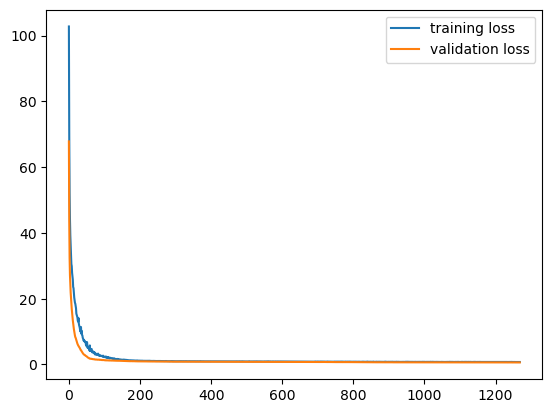

11
controls
dapi_gh2ax_lamin
HV5
hold out: HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
hold out: P44
P41
P56
P18
P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
hold out: P37
P62
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
11
 Epoch: 0000 loss_train: 106.7032 loss_val: 64.7870 time: 0.0566s


/tmp/ipykernel_1906045/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1906045/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 26.8497 loss_val: 14.1801 time: 0.0591s
 Epoch: 0020 loss_train: 16.7279 loss_val: 7.3690 time: 0.0622s
 Epoch: 0030 loss_train: 11.2395 loss_val: 5.2312 time: 0.0447s
 Epoch: 0040 loss_train: 7.1815 loss_val: 4.4836 time: 0.0484s
 Epoch: 0050 loss_train: 4.9971 loss_val: 3.6196 time: 0.0449s
 Epoch: 0060 loss_train: 4.2518 loss_val: 3.0237 time: 0.0589s
 Epoch: 0070 loss_train: 3.1307 loss_val: 2.6923 time: 0.0487s
 Epoch: 0080 loss_train: 3.2254 loss_val: 2.4165 time: 0.0483s
 Epoch: 0090 loss_train: 2.3375 loss_val: 2.1290 time: 0.0470s
 Epoch: 0100 loss_train: 2.2246 loss_val: 1.8689 time: 0.0546s
 Epoch: 0110 loss_train: 1.9084 loss_val: 1.6670 time: 0.0597s
 Epoch: 0120 loss_train: 1.9453 loss_val: 1.5482 time: 0.0442s
 Epoch: 0130 loss_train: 1.6815 loss_val: 1.4074 time: 0.0455s
 Epoch: 0140 loss_train: 1.6855 loss_val: 1.3471 time: 0.0484s
 Epoch: 0150 loss_train: 1.4917 loss_val: 1.3037 time: 0.0458s
 Epoch: 0160 loss_train: 1.4007 loss_val: 1.2451 ti

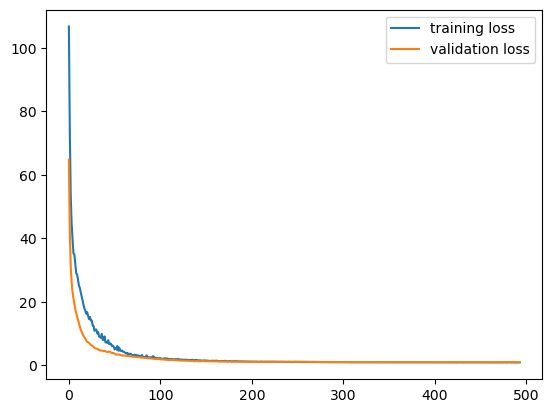

12
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
hold out: HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
12
 Epoch: 0000 loss_train: 113.4192 loss_val: 72.9484 time: 0.0624s


/tmp/ipykernel_1906045/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1906045/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 28.4122 loss_val: 15.9283 time: 0.0443s
 Epoch: 0020 loss_train: 16.7902 loss_val: 8.3104 time: 0.0451s
 Epoch: 0030 loss_train: 10.3391 loss_val: 5.4625 time: 0.0459s
 Epoch: 0040 loss_train: 7.2995 loss_val: 4.2169 time: 0.0598s
 Epoch: 0050 loss_train: 5.1678 loss_val: 3.1496 time: 0.0461s
 Epoch: 0060 loss_train: 4.4269 loss_val: 2.5073 time: 0.0456s
 Epoch: 0070 loss_train: 3.3855 loss_val: 2.2450 time: 0.0604s
 Epoch: 0080 loss_train: 2.5989 loss_val: 2.0520 time: 0.0594s
 Epoch: 0090 loss_train: 2.5154 loss_val: 2.0282 time: 0.0448s
 Epoch: 0100 loss_train: 2.1743 loss_val: 1.9361 time: 0.0462s
 Epoch: 0110 loss_train: 1.8804 loss_val: 1.8535 time: 0.0473s
 Epoch: 0120 loss_train: 1.9428 loss_val: 1.7603 time: 0.0458s
 Epoch: 0130 loss_train: 1.6759 loss_val: 1.6093 time: 0.0447s
 Epoch: 0140 loss_train: 1.4772 loss_val: 1.5491 time: 0.0455s
 Epoch: 0150 loss_train: 1.4593 loss_val: 1.5214 time: 0.0464s
 Epoch: 0160 loss_train: 1.2436 loss_val: 1.4781 ti

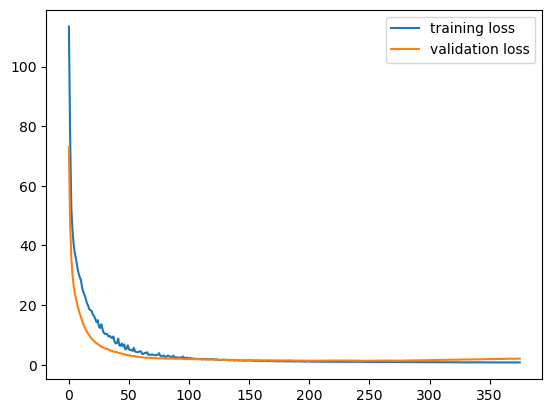

13
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
hold out: P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
hold out: P59
P38
P48
P37
P62
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
hold out: P68
13
 Epoch: 0000 loss_train: 103.4481 loss_val: 71.3555 time: 0.0623s


/tmp/ipykernel_1906045/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1906045/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 25.8429 loss_val: 15.9796 time: 0.0489s
 Epoch: 0020 loss_train: 15.5426 loss_val: 8.8835 time: 0.0484s
 Epoch: 0030 loss_train: 10.8059 loss_val: 5.2490 time: 0.0502s
 Epoch: 0040 loss_train: 7.5066 loss_val: 3.2657 time: 0.0466s
 Epoch: 0050 loss_train: 5.4100 loss_val: 2.1982 time: 0.0465s
 Epoch: 0060 loss_train: 4.4066 loss_val: 1.9042 time: 0.0475s
 Epoch: 0070 loss_train: 3.3940 loss_val: 1.7543 time: 0.0513s
 Epoch: 0080 loss_train: 2.6653 loss_val: 1.6549 time: 0.0545s
 Epoch: 0090 loss_train: 2.2415 loss_val: 1.5204 time: 0.0601s
 Epoch: 0100 loss_train: 2.1418 loss_val: 1.3856 time: 0.0593s
 Epoch: 0110 loss_train: 1.8600 loss_val: 1.3483 time: 0.0516s
 Epoch: 0120 loss_train: 1.7643 loss_val: 1.2294 time: 0.0462s
 Epoch: 0130 loss_train: 1.6494 loss_val: 1.1546 time: 0.0594s
 Epoch: 0140 loss_train: 1.5157 loss_val: 1.1075 time: 0.0509s
 Epoch: 0150 loss_train: 1.3992 loss_val: 1.0659 time: 0.0594s
 Epoch: 0160 loss_train: 1.3545 loss_val: 1.0200 ti

 Epoch: 1310 loss_train: 0.7853 loss_val: 0.5745 time: 0.0451s
 total time: 69.3606s


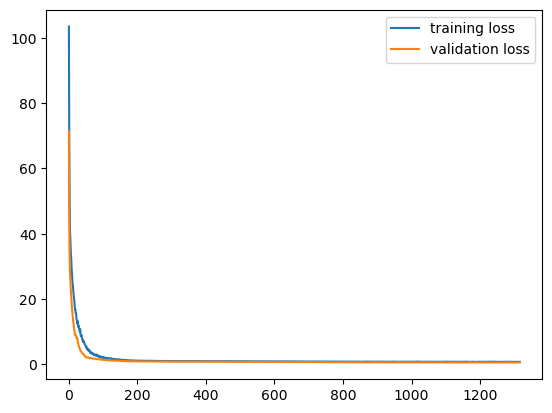

14
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
hold out: P83
P42
P59
P38
P48
P37
P62
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
hold out: P57
P15
P29
img not found P29
P68
14
 Epoch: 0000 loss_train: 103.4126 loss_val: 67.9250 time: 0.0491s


/tmp/ipykernel_1906045/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1906045/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 26.5947 loss_val: 14.8709 time: 0.0523s
 Epoch: 0020 loss_train: 16.3157 loss_val: 7.1662 time: 0.0478s
 Epoch: 0030 loss_train: 11.1159 loss_val: 4.3297 time: 0.0474s
 Epoch: 0040 loss_train: 7.9377 loss_val: 2.9300 time: 0.0537s
 Epoch: 0050 loss_train: 5.5606 loss_val: 2.1018 time: 0.0491s
 Epoch: 0060 loss_train: 3.9738 loss_val: 1.7932 time: 0.0512s
 Epoch: 0070 loss_train: 3.4922 loss_val: 1.5767 time: 0.0496s
 Epoch: 0080 loss_train: 2.7251 loss_val: 1.4468 time: 0.0484s
 Epoch: 0090 loss_train: 2.2070 loss_val: 1.3441 time: 0.0480s
 Epoch: 0100 loss_train: 2.1481 loss_val: 1.2661 time: 0.0539s
 Epoch: 0110 loss_train: 1.8763 loss_val: 1.1709 time: 0.0477s
 Epoch: 0120 loss_train: 1.6934 loss_val: 1.0920 time: 0.0459s
 Epoch: 0130 loss_train: 1.5207 loss_val: 1.0399 time: 0.0471s
 Epoch: 0140 loss_train: 1.4268 loss_val: 1.0170 time: 0.0453s
 Epoch: 0150 loss_train: 1.3570 loss_val: 0.9833 time: 0.0521s
 Epoch: 0160 loss_train: 1.2510 loss_val: 0.9611 ti

 Epoch: 1310 loss_train: 0.7806 loss_val: 0.5799 time: 0.0579s
 Epoch: 1320 loss_train: 0.7540 loss_val: 0.5733 time: 0.0635s
 Epoch: 1330 loss_train: 0.7321 loss_val: 0.5696 time: 0.0572s
 Epoch: 1340 loss_train: 0.7548 loss_val: 0.5722 time: 0.0487s
 Epoch: 1350 loss_train: 0.7406 loss_val: 0.5731 time: 0.0501s
 Epoch: 1360 loss_train: 0.7077 loss_val: 0.5706 time: 0.0540s
 Epoch: 1370 loss_train: 0.7226 loss_val: 0.5665 time: 0.0487s
 Epoch: 1380 loss_train: 0.7303 loss_val: 0.5702 time: 0.0486s
 Epoch: 1390 loss_train: 0.7415 loss_val: 0.5711 time: 0.0515s
 Epoch: 1400 loss_train: 0.7249 loss_val: 0.5656 time: 0.0491s
 Epoch: 1410 loss_train: 0.7165 loss_val: 0.5702 time: 0.0493s
 Epoch: 1420 loss_train: 0.7044 loss_val: 0.5624 time: 0.0488s
 Epoch: 1430 loss_train: 0.7085 loss_val: 0.5649 time: 0.0500s
 Epoch: 1440 loss_train: 0.7269 loss_val: 0.5620 time: 0.0562s
 Epoch: 1450 loss_train: 0.6981 loss_val: 0.5613 time: 0.0481s
 Epoch: 1460 loss_train: 0.7317 loss_val: 0.5527 time: 

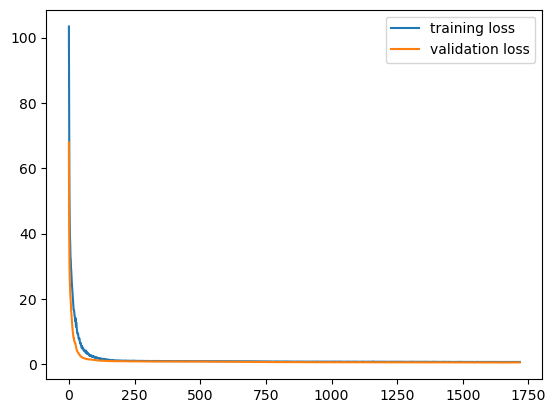

15
controls
dapi_gh2ax_lamin
HV5
hold out: HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
hold out: HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
hold out: P41
P56
hold out: P18
P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
hold out: P38
P48
P37
hold out: P62
glioma
dapi_gh2ax_lamin_cd3
P46
hold out: P16
hold out: P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
15
 Epoch: 0000 loss_train: 102.2199 loss_val: 65.3006 time: 0.0548s


/tmp/ipykernel_1906045/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1906045/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 26.6284 loss_val: 15.3296 time: 0.0588s
 Epoch: 0020 loss_train: 15.8939 loss_val: 7.9084 time: 0.0561s
 Epoch: 0030 loss_train: 10.7989 loss_val: 5.0376 time: 0.0452s
 Epoch: 0040 loss_train: 7.6248 loss_val: 3.6241 time: 0.0581s
 Epoch: 0050 loss_train: 5.1265 loss_val: 2.8832 time: 0.0634s
 Epoch: 0060 loss_train: 3.6068 loss_val: 2.4834 time: 0.0507s
 Epoch: 0070 loss_train: 2.9814 loss_val: 2.2485 time: 0.0582s
 Epoch: 0080 loss_train: 2.2574 loss_val: 2.0695 time: 0.0467s
 Epoch: 0090 loss_train: 2.1216 loss_val: 1.8091 time: 0.0486s
 Epoch: 0100 loss_train: 1.8227 loss_val: 1.5401 time: 0.0589s
 Epoch: 0110 loss_train: 1.7151 loss_val: 1.4021 time: 0.0503s
 Epoch: 0120 loss_train: 1.5335 loss_val: 1.3077 time: 0.0548s
 Epoch: 0130 loss_train: 1.5055 loss_val: 1.2211 time: 0.0492s
 Epoch: 0140 loss_train: 1.4289 loss_val: 1.1698 time: 0.0559s
 Epoch: 0150 loss_train: 1.3239 loss_val: 1.0925 time: 0.0458s
 Epoch: 0160 loss_train: 1.2057 loss_val: 1.0668 ti

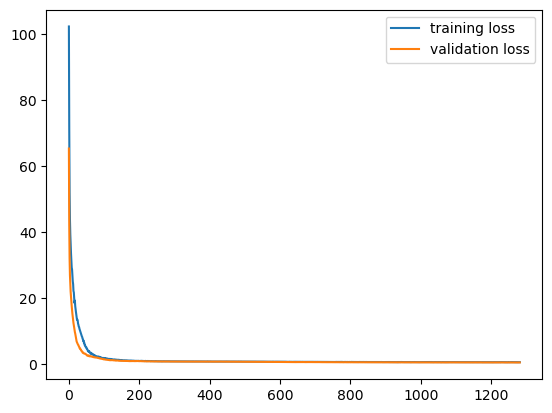

16
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
hold out: P56
P18
P55
hold out: P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
hold out: P48
P37
P62
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
hold out: P84
P47
P57
P15
P29
img not found P29
P68
16
 Epoch: 0000 loss_train: 103.5911 loss_val: 69.1237 time: 0.0518s


/tmp/ipykernel_1906045/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1906045/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 26.7107 loss_val: 15.6102 time: 0.0483s
 Epoch: 0020 loss_train: 16.8855 loss_val: 8.0803 time: 0.0490s
 Epoch: 0030 loss_train: 10.9369 loss_val: 5.1559 time: 0.0458s
 Epoch: 0040 loss_train: 8.2500 loss_val: 3.4347 time: 0.0523s
 Epoch: 0050 loss_train: 5.5637 loss_val: 2.4630 time: 0.0476s
 Epoch: 0060 loss_train: 4.3465 loss_val: 2.0520 time: 0.0470s
 Epoch: 0070 loss_train: 3.6758 loss_val: 1.7726 time: 0.0461s
 Epoch: 0080 loss_train: 2.8375 loss_val: 1.6920 time: 0.0476s
 Epoch: 0090 loss_train: 2.6422 loss_val: 1.5437 time: 0.0448s
 Epoch: 0100 loss_train: 2.1770 loss_val: 1.4031 time: 0.0458s
 Epoch: 0110 loss_train: 1.8052 loss_val: 1.3530 time: 0.0442s
 Epoch: 0120 loss_train: 1.6610 loss_val: 1.2435 time: 0.0445s
 Epoch: 0130 loss_train: 1.6212 loss_val: 1.1549 time: 0.0600s
 Epoch: 0140 loss_train: 1.4204 loss_val: 1.0996 time: 0.0466s
 Epoch: 0150 loss_train: 1.3333 loss_val: 1.0342 time: 0.0457s
 Epoch: 0160 loss_train: 1.3064 loss_val: 1.0211 ti

 Epoch: 1310 loss_train: 0.7617 loss_val: 0.6096 time: 0.0514s
 Epoch: 1320 loss_train: 0.7514 loss_val: 0.6128 time: 0.0490s
 Epoch: 1330 loss_train: 0.7623 loss_val: 0.6148 time: 0.0452s
 total time: 66.0389s


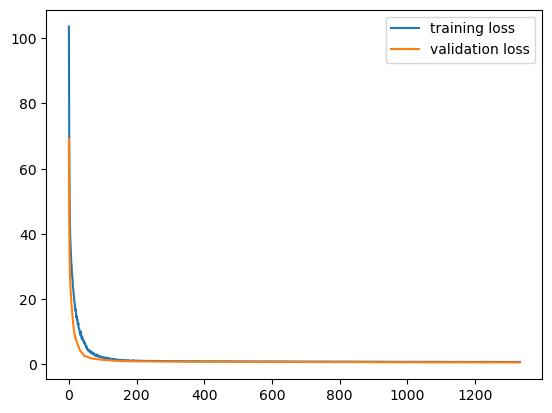

17
controls
dapi_gh2ax_lamin
HV5
hold out: HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
hold out: P44
P41
P56
P18
P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
hold out: P37
P62
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
17
 Epoch: 0000 loss_train: 107.3925 loss_val: 72.0681 time: 0.0554s


/tmp/ipykernel_1906045/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1906045/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 26.2143 loss_val: 13.9835 time: 0.0443s
 Epoch: 0020 loss_train: 16.7525 loss_val: 7.0105 time: 0.0612s
 Epoch: 0030 loss_train: 10.3451 loss_val: 4.3641 time: 0.0447s
 Epoch: 0040 loss_train: 7.5731 loss_val: 2.9821 time: 0.0465s
 Epoch: 0050 loss_train: 5.1981 loss_val: 2.2644 time: 0.0501s
 Epoch: 0060 loss_train: 5.2438 loss_val: 1.7698 time: 0.0453s
 Epoch: 0070 loss_train: 3.2143 loss_val: 1.4979 time: 0.0526s
 Epoch: 0080 loss_train: 2.9279 loss_val: 1.4305 time: 0.0468s
 Epoch: 0090 loss_train: 2.4176 loss_val: 1.3230 time: 0.0468s
 Epoch: 0100 loss_train: 2.5035 loss_val: 1.2868 time: 0.0456s
 Epoch: 0110 loss_train: 1.9382 loss_val: 1.2029 time: 0.0441s
 Epoch: 0120 loss_train: 1.7522 loss_val: 1.1634 time: 0.0482s
 Epoch: 0130 loss_train: 1.9054 loss_val: 1.1115 time: 0.0452s
 Epoch: 0140 loss_train: 1.5882 loss_val: 1.1091 time: 0.0446s
 Epoch: 0150 loss_train: 1.4611 loss_val: 1.0378 time: 0.0447s
 Epoch: 0160 loss_train: 1.3875 loss_val: 1.0148 ti

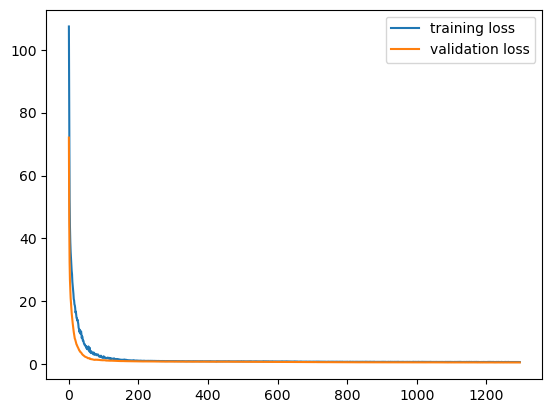

18
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
hold out: HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
18
 Epoch: 0000 loss_train: 111.8901 loss_val: 74.1571 time: 0.0587s


/tmp/ipykernel_1906045/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1906045/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 27.3464 loss_val: 14.7111 time: 0.0480s
 Epoch: 0020 loss_train: 17.7448 loss_val: 7.9793 time: 0.0485s
 Epoch: 0030 loss_train: 11.3221 loss_val: 5.1224 time: 0.0496s
 Epoch: 0040 loss_train: 7.1652 loss_val: 3.0489 time: 0.0484s
 Epoch: 0050 loss_train: 5.1407 loss_val: 2.0261 time: 0.0554s
 Epoch: 0060 loss_train: 4.0033 loss_val: 1.6865 time: 0.0517s
 Epoch: 0070 loss_train: 3.6565 loss_val: 1.5120 time: 0.0477s
 Epoch: 0080 loss_train: 2.8022 loss_val: 1.3820 time: 0.0485s
 Epoch: 0090 loss_train: 2.3334 loss_val: 1.2993 time: 0.0450s
 Epoch: 0100 loss_train: 2.0811 loss_val: 1.2756 time: 0.0447s
 Epoch: 0110 loss_train: 1.9638 loss_val: 1.2126 time: 0.0585s
 Epoch: 0120 loss_train: 1.6396 loss_val: 1.1306 time: 0.0565s
 Epoch: 0130 loss_train: 1.6108 loss_val: 1.0929 time: 0.0481s
 Epoch: 0140 loss_train: 1.6090 loss_val: 1.0746 time: 0.0472s
 Epoch: 0150 loss_train: 1.3878 loss_val: 1.0247 time: 0.0478s
 Epoch: 0160 loss_train: 1.2670 loss_val: 0.9800 ti

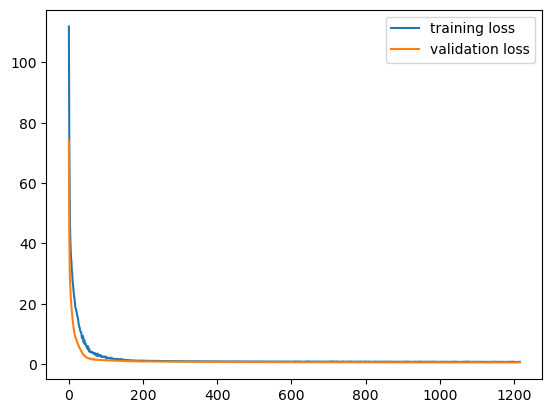

19
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
hold out: P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
hold out: P59
P38
P48
P37
P62
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
hold out: P68
19
 Epoch: 0000 loss_train: 107.2266 loss_val: 69.3717 time: 0.0571s


/tmp/ipykernel_1906045/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1906045/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 26.6720 loss_val: 14.4974 time: 0.0480s
 Epoch: 0020 loss_train: 16.4058 loss_val: 7.6328 time: 0.0476s
 Epoch: 0030 loss_train: 11.3709 loss_val: 4.9861 time: 0.0560s
 Epoch: 0040 loss_train: 9.0445 loss_val: 3.3778 time: 0.0591s
 Epoch: 0050 loss_train: 5.4663 loss_val: 2.6625 time: 0.0504s
 Epoch: 0060 loss_train: 4.6170 loss_val: 2.3803 time: 0.0501s
 Epoch: 0070 loss_train: 3.4323 loss_val: 1.9400 time: 0.0505s
 Epoch: 0080 loss_train: 3.0987 loss_val: 1.8664 time: 0.0493s
 Epoch: 0090 loss_train: 2.3652 loss_val: 1.7154 time: 0.0596s
 Epoch: 0100 loss_train: 2.3236 loss_val: 1.5674 time: 0.0465s
 Epoch: 0110 loss_train: 2.0586 loss_val: 1.4249 time: 0.0476s
 Epoch: 0120 loss_train: 1.8289 loss_val: 1.3782 time: 0.0469s
 Epoch: 0130 loss_train: 1.6855 loss_val: 1.2879 time: 0.0494s
 Epoch: 0140 loss_train: 1.5801 loss_val: 1.1819 time: 0.0470s
 Epoch: 0150 loss_train: 1.5470 loss_val: 1.1102 time: 0.0548s
 Epoch: 0160 loss_train: 1.3815 loss_val: 1.0342 ti

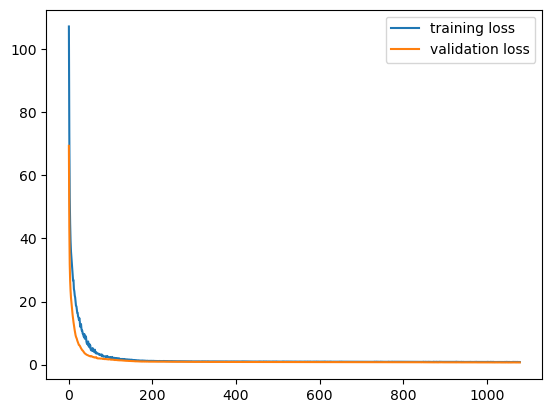

20
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
hold out: P83
P42
P59
P38
P48
P37
P62
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
hold out: P57
P15
P29
img not found P29
P68
20
 Epoch: 0000 loss_train: 107.7821 loss_val: 66.7271 time: 0.0515s


/tmp/ipykernel_1906045/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1906045/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 26.2713 loss_val: 14.4460 time: 0.0624s
 Epoch: 0020 loss_train: 16.9291 loss_val: 7.6021 time: 0.0485s
 Epoch: 0030 loss_train: 10.8556 loss_val: 5.0127 time: 0.0529s
 Epoch: 0040 loss_train: 7.1084 loss_val: 3.2467 time: 0.0637s
 Epoch: 0050 loss_train: 4.9102 loss_val: 2.0947 time: 0.0506s
 Epoch: 0060 loss_train: 4.0984 loss_val: 1.7530 time: 0.0519s
 Epoch: 0070 loss_train: 2.9660 loss_val: 1.5880 time: 0.0479s
 Epoch: 0080 loss_train: 2.4610 loss_val: 1.4563 time: 0.0500s
 Epoch: 0090 loss_train: 2.4756 loss_val: 1.3817 time: 0.0465s
 Epoch: 0100 loss_train: 2.0929 loss_val: 1.3237 time: 0.0589s
 Epoch: 0110 loss_train: 1.8992 loss_val: 1.2462 time: 0.0444s
 Epoch: 0120 loss_train: 1.8609 loss_val: 1.1951 time: 0.0631s
 Epoch: 0130 loss_train: 1.6363 loss_val: 1.1298 time: 0.0524s
 Epoch: 0140 loss_train: 1.4180 loss_val: 1.0811 time: 0.0459s
 Epoch: 0150 loss_train: 1.3330 loss_val: 1.0493 time: 0.0523s
 Epoch: 0160 loss_train: 1.2678 loss_val: 1.0150 ti

 Epoch: 1310 loss_train: 0.7625 loss_val: 0.6045 time: 0.0489s
 Epoch: 1320 loss_train: 0.7535 loss_val: 0.6052 time: 0.0572s
 Epoch: 1330 loss_train: 0.7551 loss_val: 0.6053 time: 0.0473s
 Epoch: 1340 loss_train: 0.7574 loss_val: 0.6044 time: 0.0490s
 Epoch: 1350 loss_train: 0.7357 loss_val: 0.6048 time: 0.0467s
 Epoch: 1360 loss_train: 0.7275 loss_val: 0.6057 time: 0.0521s
 Epoch: 1370 loss_train: 0.7192 loss_val: 0.6025 time: 0.0484s
 Epoch: 1380 loss_train: 0.7284 loss_val: 0.6023 time: 0.0505s
 Epoch: 1390 loss_train: 0.7505 loss_val: 0.6001 time: 0.0572s
 Epoch: 1400 loss_train: 0.7290 loss_val: 0.5997 time: 0.0497s
 Epoch: 1410 loss_train: 0.7112 loss_val: 0.5998 time: 0.0567s
 Epoch: 1420 loss_train: 0.7165 loss_val: 0.6061 time: 0.0489s
 Epoch: 1430 loss_train: 0.7290 loss_val: 0.5995 time: 0.0568s
 Epoch: 1440 loss_train: 0.7288 loss_val: 0.5970 time: 0.0507s
 Epoch: 1450 loss_train: 0.6934 loss_val: 0.5954 time: 0.0557s
 Epoch: 1460 loss_train: 0.7064 loss_val: 0.5991 time: 

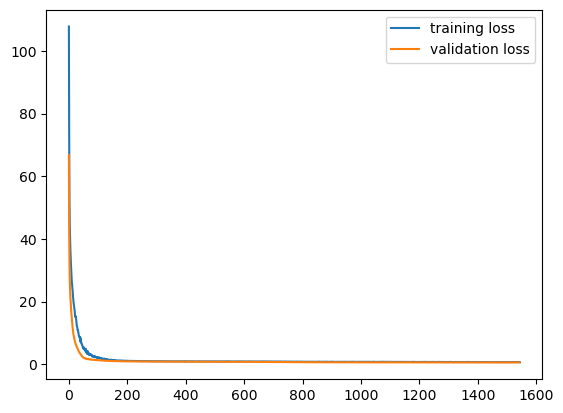

21
controls
dapi_gh2ax_lamin
HV5
hold out: HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
hold out: HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
hold out: P41
P56
hold out: P18
P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
hold out: P38
P48
P37
hold out: P62
glioma
dapi_gh2ax_lamin_cd3
P46
hold out: P16
hold out: P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
21
 Epoch: 0000 loss_train: 105.1854 loss_val: 73.4324 time: 0.0468s


/tmp/ipykernel_1906045/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1906045/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 26.5653 loss_val: 15.2320 time: 0.0504s
 Epoch: 0020 loss_train: 16.3057 loss_val: 7.9173 time: 0.0429s
 Epoch: 0030 loss_train: 11.3949 loss_val: 5.0896 time: 0.0474s
 Epoch: 0040 loss_train: 7.1923 loss_val: 3.2462 time: 0.0428s
 Epoch: 0050 loss_train: 5.2942 loss_val: 2.0338 time: 0.0485s
 Epoch: 0060 loss_train: 4.0398 loss_val: 1.6100 time: 0.0437s
 Epoch: 0070 loss_train: 3.0454 loss_val: 1.3726 time: 0.0460s
 Epoch: 0080 loss_train: 2.4614 loss_val: 1.3178 time: 0.0500s
 Epoch: 0090 loss_train: 2.1480 loss_val: 1.2665 time: 0.0431s
 Epoch: 0100 loss_train: 1.9038 loss_val: 1.2090 time: 0.0440s
 Epoch: 0110 loss_train: 1.8156 loss_val: 1.1360 time: 0.0436s
 Epoch: 0120 loss_train: 1.6119 loss_val: 1.1109 time: 0.0434s
 Epoch: 0130 loss_train: 1.4450 loss_val: 1.0563 time: 0.0483s
 Epoch: 0140 loss_train: 1.4616 loss_val: 1.0179 time: 0.0429s
 Epoch: 0150 loss_train: 1.3508 loss_val: 1.0158 time: 0.0489s
 Epoch: 0160 loss_train: 1.2352 loss_val: 0.9527 ti

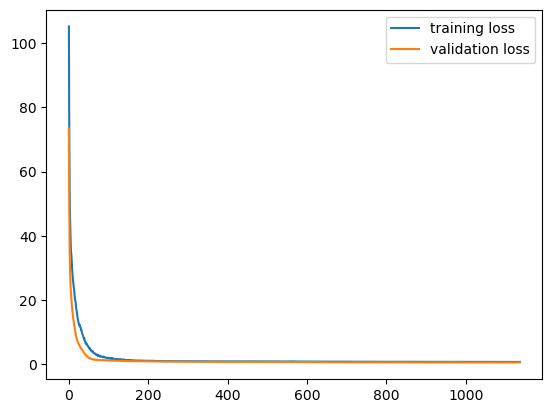

22
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
hold out: P56
P18
P55
hold out: P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
hold out: P48
P37
P62
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
hold out: P84
P47
P57
P15
P29
img not found P29
P68
22
 Epoch: 0000 loss_train: 103.5772 loss_val: 68.9667 time: 0.0485s


/tmp/ipykernel_1906045/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1906045/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 26.9699 loss_val: 15.8104 time: 0.0498s
 Epoch: 0020 loss_train: 17.2707 loss_val: 8.7242 time: 0.0445s
 Epoch: 0030 loss_train: 12.0317 loss_val: 5.7540 time: 0.0443s
 Epoch: 0040 loss_train: 8.5761 loss_val: 3.7859 time: 0.0452s
 Epoch: 0050 loss_train: 5.1447 loss_val: 2.5426 time: 0.0442s
 Epoch: 0060 loss_train: 3.9718 loss_val: 2.0867 time: 0.0449s
 Epoch: 0070 loss_train: 3.4783 loss_val: 1.7731 time: 0.0447s
 Epoch: 0080 loss_train: 2.5612 loss_val: 1.7295 time: 0.0491s
 Epoch: 0090 loss_train: 2.5083 loss_val: 1.6770 time: 0.0460s
 Epoch: 0100 loss_train: 2.0888 loss_val: 1.5228 time: 0.0486s
 Epoch: 0110 loss_train: 2.0627 loss_val: 1.4828 time: 0.0539s
 Epoch: 0120 loss_train: 1.6985 loss_val: 1.3300 time: 0.0521s
 Epoch: 0130 loss_train: 1.5840 loss_val: 1.2791 time: 0.0542s
 Epoch: 0140 loss_train: 1.4527 loss_val: 1.2278 time: 0.0600s
 Epoch: 0150 loss_train: 1.4020 loss_val: 1.1998 time: 0.0472s
 Epoch: 0160 loss_train: 1.3397 loss_val: 1.1782 ti

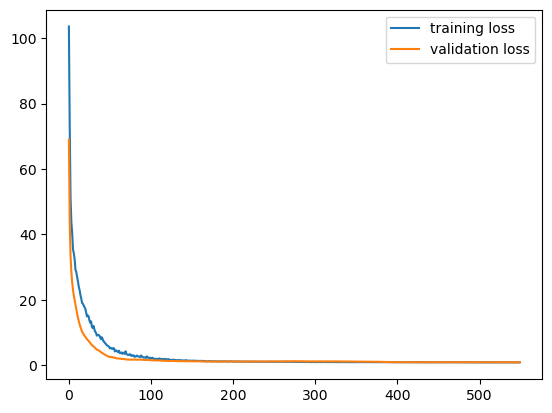

23
controls
dapi_gh2ax_lamin
HV5
hold out: HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
hold out: P44
P41
P56
P18
P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
hold out: P37
P62
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
23
 Epoch: 0000 loss_train: 110.1306 loss_val: 62.3028 time: 0.0491s


/tmp/ipykernel_1906045/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1906045/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 26.5929 loss_val: 13.9574 time: 0.0566s
 Epoch: 0020 loss_train: 15.6588 loss_val: 7.7174 time: 0.0578s
 Epoch: 0030 loss_train: 10.2474 loss_val: 4.8683 time: 0.0505s
 Epoch: 0040 loss_train: 7.8287 loss_val: 3.6676 time: 0.0519s
 Epoch: 0050 loss_train: 6.6830 loss_val: 2.7077 time: 0.0512s
 Epoch: 0060 loss_train: 4.1836 loss_val: 2.1608 time: 0.0488s
 Epoch: 0070 loss_train: 4.2077 loss_val: 1.9740 time: 0.0461s
 Epoch: 0080 loss_train: 3.0356 loss_val: 1.8172 time: 0.0449s
 Epoch: 0090 loss_train: 2.6420 loss_val: 1.7768 time: 0.0521s
 Epoch: 0100 loss_train: 2.4338 loss_val: 1.6865 time: 0.0648s
 Epoch: 0110 loss_train: 1.9937 loss_val: 1.5918 time: 0.0467s
 Epoch: 0120 loss_train: 1.8670 loss_val: 1.5309 time: 0.0491s
 Epoch: 0130 loss_train: 1.6043 loss_val: 1.4464 time: 0.0491s
 Epoch: 0140 loss_train: 1.5627 loss_val: 1.4649 time: 0.0468s
 Epoch: 0150 loss_train: 1.3979 loss_val: 1.4410 time: 0.0499s
 Epoch: 0160 loss_train: 1.3622 loss_val: 1.4138 ti

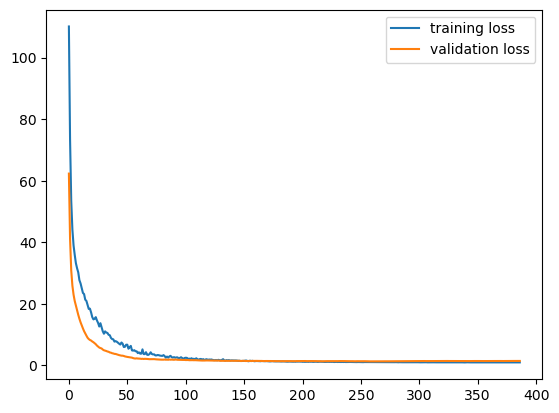

24
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
hold out: HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
24
 Epoch: 0000 loss_train: 112.3827 loss_val: 72.4449 time: 0.0645s


/tmp/ipykernel_1906045/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1906045/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 27.2146 loss_val: 15.5182 time: 0.0463s
 Epoch: 0020 loss_train: 17.1394 loss_val: 8.1411 time: 0.0645s
 Epoch: 0030 loss_train: 11.6858 loss_val: 4.9947 time: 0.0574s
 Epoch: 0040 loss_train: 7.8556 loss_val: 3.2520 time: 0.0499s
 Epoch: 0050 loss_train: 5.2326 loss_val: 2.2020 time: 0.0544s
 Epoch: 0060 loss_train: 4.1973 loss_val: 1.8110 time: 0.0464s
 Epoch: 0070 loss_train: 4.1576 loss_val: 1.5493 time: 0.0506s
 Epoch: 0080 loss_train: 3.6459 loss_val: 1.4860 time: 0.0475s
 Epoch: 0090 loss_train: 2.7177 loss_val: 1.3611 time: 0.0574s
 Epoch: 0100 loss_train: 2.2317 loss_val: 1.2529 time: 0.0592s
 Epoch: 0110 loss_train: 2.0461 loss_val: 1.3506 time: 0.0515s
 Epoch: 0120 loss_train: 1.9084 loss_val: 1.1901 time: 0.0580s
 Epoch: 0130 loss_train: 1.6662 loss_val: 1.1766 time: 0.0602s
 Epoch: 0140 loss_train: 1.6664 loss_val: 1.0938 time: 0.0636s
 Epoch: 0150 loss_train: 1.4175 loss_val: 1.0560 time: 0.0600s
 Epoch: 0160 loss_train: 1.4112 loss_val: 1.0337 ti

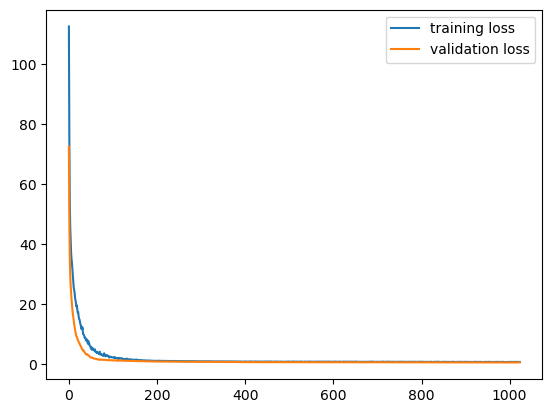

25
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
hold out: P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
hold out: P59
P38
P48
P37
P62
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
hold out: P68
25
 Epoch: 0000 loss_train: 107.0575 loss_val: 62.0547 time: 0.0545s


/tmp/ipykernel_1906045/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1906045/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 26.5372 loss_val: 14.2200 time: 0.0526s
 Epoch: 0020 loss_train: 16.1671 loss_val: 8.2797 time: 0.0494s
 Epoch: 0030 loss_train: 11.3028 loss_val: 5.9640 time: 0.0496s
 Epoch: 0040 loss_train: 7.5161 loss_val: 4.3332 time: 0.0521s
 Epoch: 0050 loss_train: 5.7673 loss_val: 4.3461 time: 0.0445s
 Epoch: 0060 loss_train: 3.9778 loss_val: 3.5703 time: 0.0454s
 Epoch: 0070 loss_train: 3.1124 loss_val: 3.1080 time: 0.0673s
 Epoch: 0080 loss_train: 2.8725 loss_val: 2.7750 time: 0.0464s
 Epoch: 0090 loss_train: 2.6399 loss_val: 2.5362 time: 0.0520s
 Epoch: 0100 loss_train: 2.2300 loss_val: 2.1014 time: 0.0535s
 Epoch: 0110 loss_train: 2.0168 loss_val: 1.9132 time: 0.0489s
 Epoch: 0120 loss_train: 1.8259 loss_val: 1.7491 time: 0.0546s
 Epoch: 0130 loss_train: 1.7875 loss_val: 1.5863 time: 0.0575s
 Epoch: 0140 loss_train: 1.4623 loss_val: 1.4900 time: 0.0462s
 Epoch: 0150 loss_train: 1.4213 loss_val: 1.4560 time: 0.0492s
 Epoch: 0160 loss_train: 1.3849 loss_val: 1.3877 ti

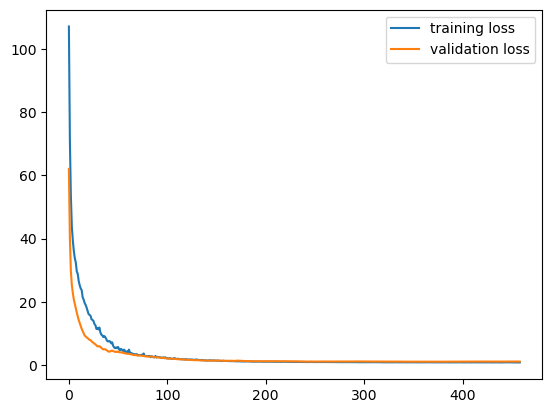

26
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
hold out: P83
P42
P59
P38
P48
P37
P62
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
hold out: P57
P15
P29
img not found P29
P68
26
 Epoch: 0000 loss_train: 104.7267 loss_val: 70.4467 time: 0.0562s


/tmp/ipykernel_1906045/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1906045/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 26.7327 loss_val: 16.0023 time: 0.0556s
 Epoch: 0020 loss_train: 16.2148 loss_val: 8.6425 time: 0.0492s
 Epoch: 0030 loss_train: 10.7651 loss_val: 5.5138 time: 0.0627s
 Epoch: 0040 loss_train: 6.9883 loss_val: 3.3071 time: 0.0484s
 Epoch: 0050 loss_train: 5.1924 loss_val: 2.2111 time: 0.0487s
 Epoch: 0060 loss_train: 4.1591 loss_val: 1.8561 time: 0.0618s
 Epoch: 0070 loss_train: 3.7287 loss_val: 1.6893 time: 0.0492s
 Epoch: 0080 loss_train: 2.8128 loss_val: 1.4897 time: 0.0509s
 Epoch: 0090 loss_train: 2.3249 loss_val: 1.4086 time: 0.0522s
 Epoch: 0100 loss_train: 2.0761 loss_val: 1.3203 time: 0.0502s
 Epoch: 0110 loss_train: 2.0686 loss_val: 1.2176 time: 0.0489s
 Epoch: 0120 loss_train: 1.8786 loss_val: 1.2292 time: 0.0674s
 Epoch: 0130 loss_train: 1.6559 loss_val: 1.1229 time: 0.0471s
 Epoch: 0140 loss_train: 1.4985 loss_val: 1.0660 time: 0.0549s
 Epoch: 0150 loss_train: 1.3448 loss_val: 1.0255 time: 0.0462s
 Epoch: 0160 loss_train: 1.3229 loss_val: 1.0043 ti

 Epoch: 1310 loss_train: 0.7654 loss_val: 0.6140 time: 0.0574s
 Epoch: 1320 loss_train: 0.7739 loss_val: 0.6160 time: 0.0664s
 Epoch: 1330 loss_train: 0.7416 loss_val: 0.6088 time: 0.0689s
 Epoch: 1340 loss_train: 0.7438 loss_val: 0.6106 time: 0.0513s
 Epoch: 1350 loss_train: 0.7347 loss_val: 0.6089 time: 0.0553s
 Epoch: 1360 loss_train: 0.7527 loss_val: 0.6066 time: 0.0625s
 Epoch: 1370 loss_train: 0.7598 loss_val: 0.6101 time: 0.0592s
 Epoch: 1380 loss_train: 0.7476 loss_val: 0.6130 time: 0.0546s
 Epoch: 1390 loss_train: 0.7383 loss_val: 0.6076 time: 0.0568s
 Epoch: 1400 loss_train: 0.7276 loss_val: 0.6085 time: 0.0500s
 Epoch: 1410 loss_train: 0.7186 loss_val: 0.6060 time: 0.0497s
 Epoch: 1420 loss_train: 0.7236 loss_val: 0.6026 time: 0.0556s
 Epoch: 1430 loss_train: 0.7244 loss_val: 0.6016 time: 0.0502s
 Epoch: 1440 loss_train: 0.7397 loss_val: 0.6014 time: 0.0497s
 Epoch: 1450 loss_train: 0.7299 loss_val: 0.6057 time: 0.0500s
 Epoch: 1460 loss_train: 0.7273 loss_val: 0.5997 time: 

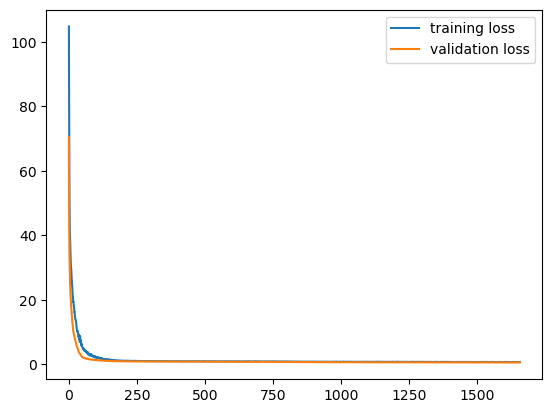

27
controls
dapi_gh2ax_lamin
HV5
hold out: HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
hold out: HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
hold out: P41
P56
hold out: P18
P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
hold out: P38
P48
P37
hold out: P62
glioma
dapi_gh2ax_lamin_cd3
P46
hold out: P16
hold out: P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
27
 Epoch: 0000 loss_train: 102.3015 loss_val: 69.3606 time: 0.0457s


/tmp/ipykernel_1906045/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1906045/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 26.6441 loss_val: 15.0061 time: 0.0476s
 Epoch: 0020 loss_train: 15.6998 loss_val: 7.4210 time: 0.0451s
 Epoch: 0030 loss_train: 10.5752 loss_val: 4.9393 time: 0.0464s
 Epoch: 0040 loss_train: 7.2707 loss_val: 3.7054 time: 0.0481s
 Epoch: 0050 loss_train: 4.9857 loss_val: 2.8407 time: 0.0488s
 Epoch: 0060 loss_train: 3.7764 loss_val: 2.3658 time: 0.0452s
 Epoch: 0070 loss_train: 3.1189 loss_val: 2.1304 time: 0.0484s
 Epoch: 0080 loss_train: 2.7459 loss_val: 1.8883 time: 0.0476s
 Epoch: 0090 loss_train: 2.4325 loss_val: 1.6200 time: 0.0516s
 Epoch: 0100 loss_train: 1.9863 loss_val: 1.4659 time: 0.0456s
 Epoch: 0110 loss_train: 1.6992 loss_val: 1.3621 time: 0.0478s
 Epoch: 0120 loss_train: 1.6283 loss_val: 1.2372 time: 0.0593s
 Epoch: 0130 loss_train: 1.5135 loss_val: 1.1611 time: 0.0444s
 Epoch: 0140 loss_train: 1.4352 loss_val: 1.1092 time: 0.0444s
 Epoch: 0150 loss_train: 1.4152 loss_val: 1.0675 time: 0.0451s
 Epoch: 0160 loss_train: 1.2466 loss_val: 1.0300 ti

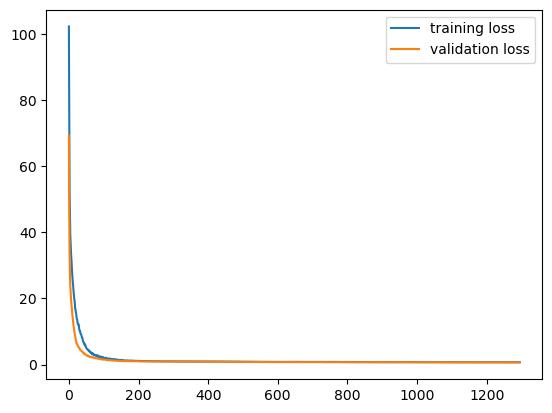

28
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
hold out: P56
P18
P55
hold out: P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
hold out: P48
P37
P62
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
hold out: P84
P47
P57
P15
P29
img not found P29
P68
28
 Epoch: 0000 loss_train: 103.3178 loss_val: 69.5601 time: 0.0546s


/tmp/ipykernel_1906045/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1906045/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 26.7525 loss_val: 15.8894 time: 0.0494s
 Epoch: 0020 loss_train: 16.6339 loss_val: 9.1439 time: 0.0557s
 Epoch: 0030 loss_train: 10.8534 loss_val: 7.0630 time: 0.0605s
 Epoch: 0040 loss_train: 7.0297 loss_val: 5.5154 time: 0.0450s
 Epoch: 0050 loss_train: 4.6812 loss_val: 4.9022 time: 0.0448s
 Epoch: 0060 loss_train: 3.8239 loss_val: 4.1588 time: 0.0460s
 Epoch: 0070 loss_train: 3.0582 loss_val: 3.6811 time: 0.0490s
 Epoch: 0080 loss_train: 2.4580 loss_val: 3.3034 time: 0.0458s
 Epoch: 0090 loss_train: 2.4690 loss_val: 2.9101 time: 0.0518s
 Epoch: 0100 loss_train: 2.0786 loss_val: 2.6783 time: 0.0450s
 Epoch: 0110 loss_train: 1.8814 loss_val: 2.2842 time: 0.0458s
 Epoch: 0120 loss_train: 1.7051 loss_val: 2.0173 time: 0.0447s
 Epoch: 0130 loss_train: 1.5884 loss_val: 1.9142 time: 0.0481s
 Epoch: 0140 loss_train: 1.4048 loss_val: 1.7384 time: 0.0479s
 Epoch: 0150 loss_train: 1.3970 loss_val: 1.6387 time: 0.0522s
 Epoch: 0160 loss_train: 1.2786 loss_val: 1.6055 ti

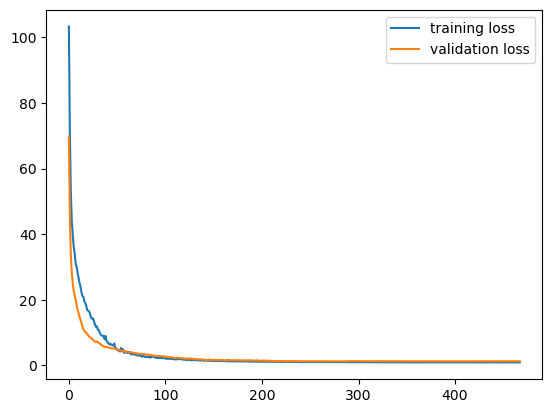

29
controls
dapi_gh2ax_lamin
HV5
hold out: HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
hold out: P44
P41
P56
P18
P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
hold out: P37
P62
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
29
 Epoch: 0000 loss_train: 108.0200 loss_val: 68.5529 time: 0.0616s


/tmp/ipykernel_1906045/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1906045/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 26.4958 loss_val: 15.0606 time: 0.0468s
 Epoch: 0020 loss_train: 16.2865 loss_val: 7.9891 time: 0.0476s
 Epoch: 0030 loss_train: 11.2814 loss_val: 5.0146 time: 0.0538s
 Epoch: 0040 loss_train: 7.7674 loss_val: 3.2418 time: 0.0550s
 Epoch: 0050 loss_train: 5.2629 loss_val: 2.2163 time: 0.0519s
 Epoch: 0060 loss_train: 4.3318 loss_val: 1.8879 time: 0.0501s
 Epoch: 0070 loss_train: 3.3032 loss_val: 1.7493 time: 0.0485s
 Epoch: 0080 loss_train: 2.5370 loss_val: 1.5713 time: 0.0517s
 Epoch: 0090 loss_train: 2.5089 loss_val: 1.4358 time: 0.0505s
 Epoch: 0100 loss_train: 2.2412 loss_val: 1.3417 time: 0.0552s
 Epoch: 0110 loss_train: 1.8643 loss_val: 1.2600 time: 0.0491s
 Epoch: 0120 loss_train: 1.8314 loss_val: 1.2157 time: 0.0625s
 Epoch: 0130 loss_train: 1.5737 loss_val: 1.1524 time: 0.0487s
 Epoch: 0140 loss_train: 1.5246 loss_val: 1.1113 time: 0.0502s
 Epoch: 0150 loss_train: 1.5282 loss_val: 1.0337 time: 0.0495s
 Epoch: 0160 loss_train: 1.3582 loss_val: 1.0135 ti

 Epoch: 1310 loss_train: 0.7306 loss_val: 0.6025 time: 0.0511s
 Epoch: 1320 loss_train: 0.7492 loss_val: 0.6050 time: 0.0480s
 Epoch: 1330 loss_train: 0.7757 loss_val: 0.6027 time: 0.0516s
 Epoch: 1340 loss_train: 0.7392 loss_val: 0.5990 time: 0.0472s
 Epoch: 1350 loss_train: 0.7363 loss_val: 0.5927 time: 0.0511s
 Epoch: 1360 loss_train: 0.7202 loss_val: 0.6018 time: 0.0526s
 Epoch: 1370 loss_train: 0.7175 loss_val: 0.6017 time: 0.0438s
 Epoch: 1380 loss_train: 0.7085 loss_val: 0.5942 time: 0.0452s
 Epoch: 1390 loss_train: 0.7155 loss_val: 0.5934 time: 0.0448s
 Epoch: 1400 loss_train: 0.7496 loss_val: 0.5944 time: 0.0460s
 Epoch: 1410 loss_train: 0.7389 loss_val: 0.5906 time: 0.0478s
 Epoch: 1420 loss_train: 0.7089 loss_val: 0.5877 time: 0.0447s
 Epoch: 1430 loss_train: 0.7544 loss_val: 0.5913 time: 0.0476s
 Epoch: 1440 loss_train: 0.7249 loss_val: 0.5839 time: 0.0480s
 Epoch: 1450 loss_train: 0.7128 loss_val: 0.5961 time: 0.0465s
 Epoch: 1460 loss_train: 0.7449 loss_val: 0.5868 time: 

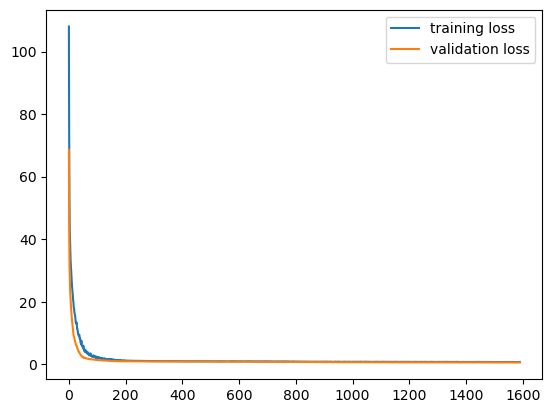

30
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
hold out: HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
30
 Epoch: 0000 loss_train: 114.2143 loss_val: 71.8794 time: 0.0464s


/tmp/ipykernel_1906045/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1906045/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 26.8036 loss_val: 16.6296 time: 0.0464s
 Epoch: 0020 loss_train: 16.3678 loss_val: 9.0572 time: 0.0504s
 Epoch: 0030 loss_train: 11.3142 loss_val: 6.6767 time: 0.0444s
 Epoch: 0040 loss_train: 8.9943 loss_val: 6.3719 time: 0.0475s
 Epoch: 0050 loss_train: 5.4046 loss_val: 6.6130 time: 0.0510s
 Epoch: 0060 loss_train: 4.5522 loss_val: 5.6941 time: 0.0456s
 Epoch: 0070 loss_train: 3.8786 loss_val: 5.0872 time: 0.0488s
 Epoch: 0080 loss_train: 2.8164 loss_val: 4.7447 time: 0.0584s
 Epoch: 0090 loss_train: 2.3942 loss_val: 4.3468 time: 0.0538s
 Epoch: 0100 loss_train: 2.5617 loss_val: 3.8261 time: 0.0488s
 Epoch: 0110 loss_train: 2.0693 loss_val: 3.1626 time: 0.0569s
 Epoch: 0120 loss_train: 1.9533 loss_val: 2.7495 time: 0.0577s
 Epoch: 0130 loss_train: 1.7683 loss_val: 2.4275 time: 0.0479s
 Epoch: 0140 loss_train: 1.7622 loss_val: 2.0980 time: 0.0462s
 Epoch: 0150 loss_train: 1.4584 loss_val: 2.0113 time: 0.0478s
 Epoch: 0160 loss_train: 1.4204 loss_val: 1.9579 ti

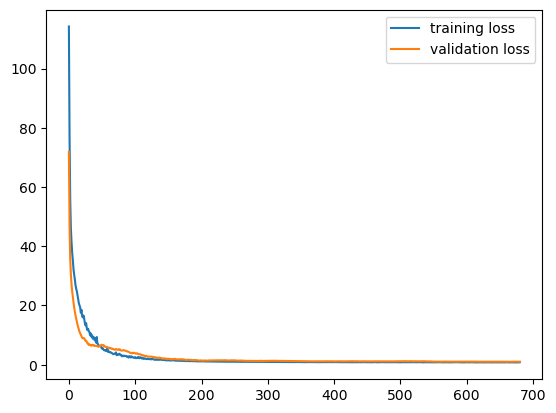

31
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
hold out: P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
hold out: P59
P38
P48
P37
P62
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
hold out: P68
31
 Epoch: 0000 loss_train: 106.3048 loss_val: 67.6964 time: 0.0453s


/tmp/ipykernel_1906045/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1906045/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 27.2009 loss_val: 15.3333 time: 0.0485s
 Epoch: 0020 loss_train: 17.5199 loss_val: 8.4948 time: 0.0478s
 Epoch: 0030 loss_train: 11.3320 loss_val: 5.5905 time: 0.0458s
 Epoch: 0040 loss_train: 7.9284 loss_val: 3.6205 time: 0.0530s
 Epoch: 0050 loss_train: 6.1907 loss_val: 2.6473 time: 0.0452s
 Epoch: 0060 loss_train: 4.2769 loss_val: 1.9937 time: 0.0470s
 Epoch: 0070 loss_train: 3.8912 loss_val: 1.8508 time: 0.0556s
 Epoch: 0080 loss_train: 3.2392 loss_val: 1.7090 time: 0.0475s
 Epoch: 0090 loss_train: 2.8762 loss_val: 1.5910 time: 0.0481s
 Epoch: 0100 loss_train: 2.2990 loss_val: 1.5260 time: 0.0488s
 Epoch: 0110 loss_train: 1.9892 loss_val: 1.3885 time: 0.0449s
 Epoch: 0120 loss_train: 1.7888 loss_val: 1.3287 time: 0.0508s
 Epoch: 0130 loss_train: 1.6839 loss_val: 1.2811 time: 0.0492s
 Epoch: 0140 loss_train: 1.5907 loss_val: 1.2056 time: 0.0469s
 Epoch: 0150 loss_train: 1.4508 loss_val: 1.1509 time: 0.0470s
 Epoch: 0160 loss_train: 1.3720 loss_val: 1.0887 ti

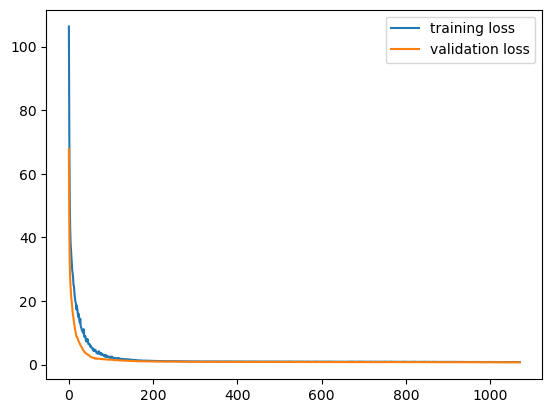

32
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
hold out: P83
P42
P59
P38
P48
P37
P62
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
hold out: P57
P15
P29
img not found P29
P68
32
 Epoch: 0000 loss_train: 102.3610 loss_val: 68.2122 time: 0.0500s


/tmp/ipykernel_1906045/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1906045/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 26.2728 loss_val: 15.4188 time: 0.0476s
 Epoch: 0020 loss_train: 16.5874 loss_val: 8.2749 time: 0.0646s
 Epoch: 0030 loss_train: 11.1841 loss_val: 5.3239 time: 0.0741s
 Epoch: 0040 loss_train: 7.9876 loss_val: 3.5540 time: 0.0691s
 Epoch: 0050 loss_train: 5.0786 loss_val: 2.5196 time: 0.0604s
 Epoch: 0060 loss_train: 3.9569 loss_val: 2.0967 time: 0.0508s
 Epoch: 0070 loss_train: 2.9481 loss_val: 1.9136 time: 0.0549s
 Epoch: 0080 loss_train: 2.5609 loss_val: 1.6939 time: 0.0487s
 Epoch: 0090 loss_train: 2.4135 loss_val: 1.5570 time: 0.0522s
 Epoch: 0100 loss_train: 2.0159 loss_val: 1.4447 time: 0.0522s
 Epoch: 0110 loss_train: 1.8502 loss_val: 1.3796 time: 0.0618s
 Epoch: 0120 loss_train: 1.6187 loss_val: 1.2510 time: 0.0590s
 Epoch: 0130 loss_train: 1.5127 loss_val: 1.1917 time: 0.0474s
 Epoch: 0140 loss_train: 1.3946 loss_val: 1.1045 time: 0.0447s
 Epoch: 0150 loss_train: 1.3343 loss_val: 1.0653 time: 0.0463s
 Epoch: 0160 loss_train: 1.2881 loss_val: 1.0309 ti

 Epoch: 1310 loss_train: 0.7146 loss_val: 0.5887 time: 0.0481s
 Epoch: 1320 loss_train: 0.7281 loss_val: 0.5912 time: 0.0484s
 Epoch: 1330 loss_train: 0.7233 loss_val: 0.5916 time: 0.0492s
 Epoch: 1340 loss_train: 0.7129 loss_val: 0.5854 time: 0.0487s
 Epoch: 1350 loss_train: 0.7027 loss_val: 0.5871 time: 0.0493s
 Epoch: 1360 loss_train: 0.6966 loss_val: 0.5864 time: 0.0636s
 Epoch: 1370 loss_train: 0.7198 loss_val: 0.5897 time: 0.0718s
 Epoch: 1380 loss_train: 0.7274 loss_val: 0.5861 time: 0.0521s
 Epoch: 1390 loss_train: 0.7206 loss_val: 0.5825 time: 0.0568s
 Epoch: 1400 loss_train: 0.7396 loss_val: 0.5840 time: 0.0524s
 Epoch: 1410 loss_train: 0.7136 loss_val: 0.5785 time: 0.0516s
 Epoch: 1420 loss_train: 0.7148 loss_val: 0.5788 time: 0.0610s
 Epoch: 1430 loss_train: 0.6959 loss_val: 0.5801 time: 0.0591s
 Epoch: 1440 loss_train: 0.7066 loss_val: 0.5804 time: 0.0490s
 Epoch: 1450 loss_train: 0.7099 loss_val: 0.5810 time: 0.0546s
 Epoch: 1460 loss_train: 0.7078 loss_val: 0.5806 time: 

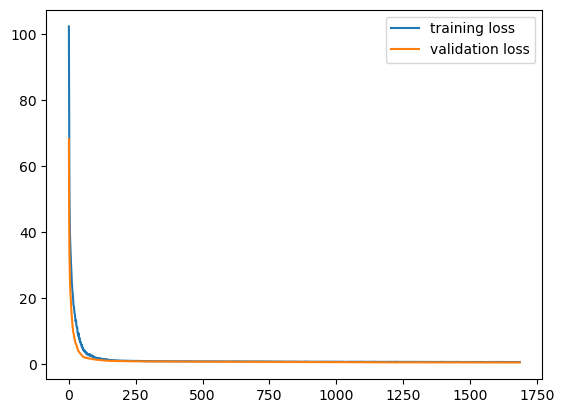

33
controls
dapi_gh2ax_lamin
HV5
hold out: HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
hold out: HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
hold out: P41
P56
hold out: P18
P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
hold out: P38
P48
P37
hold out: P62
glioma
dapi_gh2ax_lamin_cd3
P46
hold out: P16
hold out: P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
33
 Epoch: 0000 loss_train: 102.3391 loss_val: 70.1960 time: 0.0515s


/tmp/ipykernel_1906045/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1906045/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 27.6945 loss_val: 14.4071 time: 0.0504s
 Epoch: 0020 loss_train: 16.2051 loss_val: 7.2429 time: 0.0460s
 Epoch: 0030 loss_train: 11.4010 loss_val: 4.9219 time: 0.0467s
 Epoch: 0040 loss_train: 7.4067 loss_val: 3.1526 time: 0.0528s
 Epoch: 0050 loss_train: 5.3395 loss_val: 2.1659 time: 0.0497s
 Epoch: 0060 loss_train: 4.1129 loss_val: 1.6548 time: 0.0575s
 Epoch: 0070 loss_train: 3.0386 loss_val: 1.4732 time: 0.0458s
 Epoch: 0080 loss_train: 2.6182 loss_val: 1.3848 time: 0.0469s
 Epoch: 0090 loss_train: 2.1449 loss_val: 1.2873 time: 0.0595s
 Epoch: 0100 loss_train: 1.9043 loss_val: 1.2204 time: 0.0649s
 Epoch: 0110 loss_train: 1.7894 loss_val: 1.1670 time: 0.0532s
 Epoch: 0120 loss_train: 1.7012 loss_val: 1.0936 time: 0.0460s
 Epoch: 0130 loss_train: 1.5236 loss_val: 1.0520 time: 0.0537s
 Epoch: 0140 loss_train: 1.4623 loss_val: 1.0206 time: 0.0453s
 Epoch: 0150 loss_train: 1.3627 loss_val: 0.9844 time: 0.0466s
 Epoch: 0160 loss_train: 1.2595 loss_val: 0.9432 ti

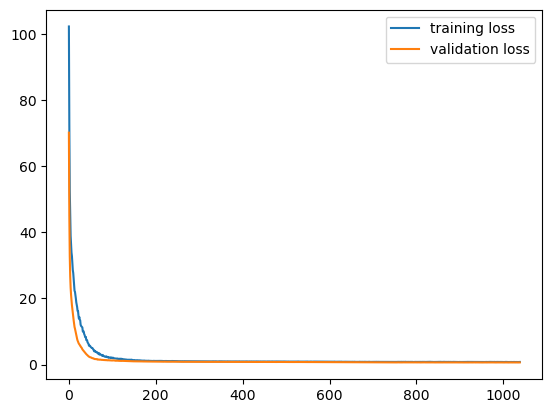

34
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
hold out: P56
P18
P55
hold out: P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
hold out: P48
P37
P62
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
hold out: P84
P47
P57
P15
P29
img not found P29
P68
34
 Epoch: 0000 loss_train: 103.5816 loss_val: 68.4757 time: 0.0480s


/tmp/ipykernel_1906045/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1906045/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 27.4649 loss_val: 15.9881 time: 0.0484s
 Epoch: 0020 loss_train: 15.8739 loss_val: 8.4789 time: 0.0461s
 Epoch: 0030 loss_train: 11.2681 loss_val: 5.8081 time: 0.0546s
 Epoch: 0040 loss_train: 7.6092 loss_val: 3.8702 time: 0.0460s
 Epoch: 0050 loss_train: 5.5865 loss_val: 3.1313 time: 0.0468s
 Epoch: 0060 loss_train: 4.1636 loss_val: 2.7835 time: 0.0470s
 Epoch: 0070 loss_train: 3.8173 loss_val: 2.4506 time: 0.0466s
 Epoch: 0080 loss_train: 2.9228 loss_val: 2.1915 time: 0.0468s
 Epoch: 0090 loss_train: 2.6749 loss_val: 1.9808 time: 0.0573s
 Epoch: 0100 loss_train: 2.2348 loss_val: 1.6656 time: 0.0458s
 Epoch: 0110 loss_train: 2.2847 loss_val: 1.6091 time: 0.0458s
 Epoch: 0120 loss_train: 1.8283 loss_val: 1.5079 time: 0.0528s
 Epoch: 0130 loss_train: 1.6912 loss_val: 1.3603 time: 0.0457s
 Epoch: 0140 loss_train: 1.5242 loss_val: 1.2228 time: 0.0588s
 Epoch: 0150 loss_train: 1.5548 loss_val: 1.1906 time: 0.0490s
 Epoch: 0160 loss_train: 1.3376 loss_val: 1.0889 ti

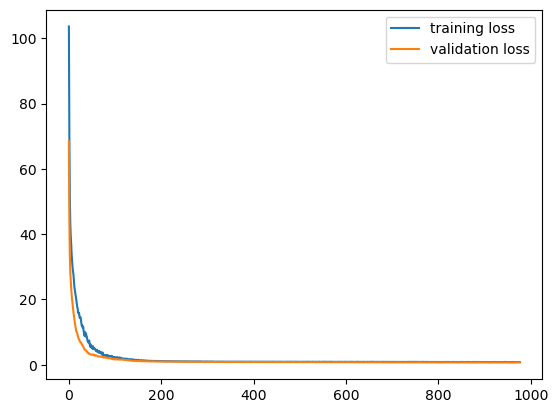

35
controls
dapi_gh2ax_lamin
HV5
hold out: HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
hold out: P44
P41
P56
P18
P55
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
hold out: P37
P62
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
35
 Epoch: 0000 loss_train: 106.7333 loss_val: 68.7021 time: 0.0494s


/tmp/ipykernel_1906045/2799474366.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1906045/2799474366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0010 loss_train: 27.2292 loss_val: 14.9395 time: 0.0461s
 Epoch: 0020 loss_train: 15.4886 loss_val: 8.2074 time: 0.0466s
 Epoch: 0030 loss_train: 10.8392 loss_val: 5.6488 time: 0.0524s
 Epoch: 0040 loss_train: 7.8548 loss_val: 3.2438 time: 0.0533s
 Epoch: 0050 loss_train: 5.4280 loss_val: 2.2350 time: 0.0457s
 Epoch: 0060 loss_train: 4.5124 loss_val: 1.8411 time: 0.0474s
 Epoch: 0070 loss_train: 2.8930 loss_val: 1.4751 time: 0.0568s
 Epoch: 0080 loss_train: 2.6985 loss_val: 1.4245 time: 0.0456s
 Epoch: 0090 loss_train: 2.1573 loss_val: 1.3627 time: 0.0459s
 Epoch: 0100 loss_train: 1.9448 loss_val: 1.2594 time: 0.0632s
 Epoch: 0110 loss_train: 1.8152 loss_val: 1.1994 time: 0.0549s
 Epoch: 0120 loss_train: 1.8029 loss_val: 1.1659 time: 0.0470s
 Epoch: 0130 loss_train: 1.5124 loss_val: 1.1330 time: 0.0475s
 Epoch: 0140 loss_train: 1.4574 loss_val: 1.1564 time: 0.0534s
 Epoch: 0150 loss_train: 1.3424 loss_val: 1.0358 time: 0.0642s
 Epoch: 0160 loss_train: 1.3761 loss_val: 1.0302 ti

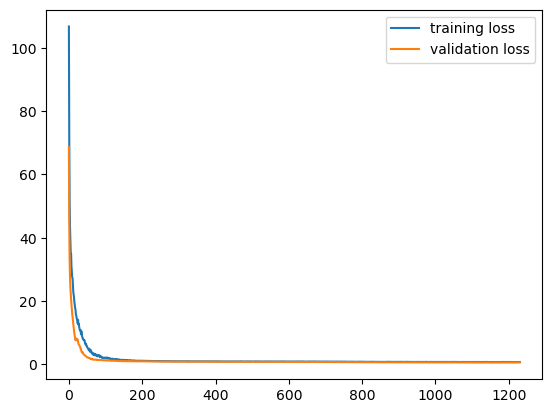

In [8]:
pnames=['gh2ax','cd4','cd8','lamin','cd3','cd16']
for p in pnames:
    print(p)
    with open(os.path.join(sourceDir,'nmco_allfeatures_names_'+p), 'rb') as output:
        nmco_names=pickle.load(output)
    with open(os.path.join(sourceDir,'ls_cc_mostConnected_'+p), 'rb') as output:
        ls_cc_mostConnected=pickle.load(output)
    
    for nmcoFeature in ls_cc_mostConnected:
#     for nmcoFeature in ['gh2ax_foci_count']:
        print(nmcoFeature)
        nmcoFeatureIdx=list(nmco_names).index(nmcoFeature)
        for sample_s in range(prevSampled,nSamples):
            print(sample_s)
            nmco_all_samples_s=None
            imgNames_all_samples_s=None
            pID_all_samples_s=None
            conditions_all_samples_s=None

            for condition_i in conditions:
                print(condition_i)
                segDir_i=os.path.join(segDir,condition_i)
                imgDir_i=os.path.join(imgDir,condition_i)
                for stain in os.listdir(segDir_i):
                    if p not in stain:
                        continue
                    print(stain)
                    segDir_i_stain=os.path.join(segDir_i,stain)
                    imgDir_i_stain=os.path.join(imgDir_i,stain)

                    segPID2name={}
                    for pID_dir in os.listdir(segDir_i_stain):
                        pID=pID_dir.split('_')
                        segPID2name[pID[0]]=pID_dir
                    imgPID2name={}
                    for pID_dir in os.listdir(imgDir_i_stain):
                        pID=pID_dir.split('_')
                        imgPID2name[pID[0]]=pID_dir
                    for pID in segPID2name.keys():
                        if condition_i=='meningioma' and stain=='dapi_gh2ax_lamin_cd3' and pID=='P33': #skipping incorrect images
                            continue
                        if pID in holdOutSamples_samples[sample_s%6]:
                            print('hold out: '+pID)
                            continue
                        print(pID)
                        if pID not in imgPID2name:
                            print('img not found '+pID)
                            continue
                        imgDir_i_stain_p=os.path.join(imgDir_i_stain,imgPID2name[pID])
                        segDir_i_stain_p=os.path.join(segDir_i_stain,segPID2name[pID])

                        with open(os.path.join(imgDir_i_stain_p,savename+'_imgNames'), 'rb') as output:
                            imgNames=pickle.load(output)
                        with open(os.path.join(imgDir_i_stain_p,'nmco_allfeatures_protein'), 'rb') as output:
                            nmco_p=pickle.load(output)[p]

                        nmco_p=np.concatenate((nmco_p[:,:nmcoFeatureIdx],nmco_p[:,nmcoFeatureIdx+1:]),axis=1)

                        if nmco_all_samples_s is None:
                            pID_all_samples_s=np.repeat(pID,imgNames.shape[0])
                            nmco_all_samples_s=nmco_p
                            imgNames_all_samples_s=imgNames
                            conditions_all_samples_s=np.repeat(condition_i,imgNames.shape[0])
                        else:
                            pID_all_samples_s=np.concatenate((pID_all_samples_s,np.repeat(pID,imgNames.shape[0])))
                            nmco_all_samples_s=np.concatenate((nmco_all_samples_s,nmco_p),axis=0)
                            imgNames_all_samples_s=np.concatenate((imgNames_all_samples_s,imgNames))
                            conditions_all_samples_s=np.concatenate((conditions_all_samples_s,np.repeat(condition_i,imgNames.shape[0])))

            print(sample_s)

            logsavepath_train_curr=os.path.join(logsavepath_train,p)
            modelsavepath_train_curr=os.path.join(modelsavepath_train,p)
            plotsavepath_train_curr=os.path.join(plotsavepath_train,p)
            if not os.path.exists(logsavepath_train_curr):
                os.mkdir(logsavepath_train_curr)
            if not os.path.exists(modelsavepath_train_curr):
                os.mkdir(modelsavepath_train_curr)
            if not os.path.exists(plotsavepath_train_curr):
                os.mkdir(plotsavepath_train_curr)
            logsavepath_train_curr=os.path.join(logsavepath_train_curr,nmcoFeature)
            modelsavepath_train_curr=os.path.join(modelsavepath_train_curr,nmcoFeature)
            plotsavepath_train_curr=os.path.join(plotsavepath_train_curr,nmcoFeature)
            if not os.path.exists(logsavepath_train_curr):
                os.mkdir(logsavepath_train_curr)
            if not os.path.exists(modelsavepath_train_curr):
                os.mkdir(modelsavepath_train_curr)
            if not os.path.exists(plotsavepath_train_curr):
                os.mkdir(plotsavepath_train_curr)
            logsavepath_train_curr=os.path.join(logsavepath_train_curr,str(sample_s))
            modelsavepath_train_curr=os.path.join(modelsavepath_train_curr,str(sample_s))
            plotsavepath_train_curr=os.path.join(plotsavepath_train_curr,str(sample_s))
            if not os.path.exists(logsavepath_train_curr):
                os.mkdir(logsavepath_train_curr)
            if not os.path.exists(modelsavepath_train_curr):
                os.mkdir(modelsavepath_train_curr)
            if not os.path.exists(plotsavepath_train_curr):
                os.mkdir(plotsavepath_train_curr)

            np.random.seed(sample_s)
            nvalSamples=int(valRatio*conditions_all_samples_s.size)
            allIdx=np.arange(conditions_all_samples_s.size)
            np.random.shuffle(allIdx)
            valIdx=allIdx[:nvalSamples]
            trainIdx=allIdx[nvalSamples:]

            conditions_all_curr=conditions_all_samples_s[trainIdx]
            cnames,revIdx_c,cCounts=np.unique(conditions_all_curr,return_inverse=True,return_counts=True)
            clfWeight=1/cCounts
            clfWeight=clfWeight/np.sum(clfWeight)
            loss_clf=torch.nn.CrossEntropyLoss(weight=torch.tensor(clfWeight).cuda().float())
            cnames_val,revIdx_c_val,cCounts_val=np.unique(conditions_all_samples_s[valIdx],return_inverse=True,return_counts=True)

            np.random.seed(seed)
            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)
            torch.backends.cudnn.enabled = True
            if modelname_train=='nmco2cond_fc_l2':
                model=FC_l2(nmco_all_samples_s.shape[1],8,8,cnames.size)
            model.cuda()
            optimizer_clf = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

            train_loss=[np.inf]*epochs
            val_loss=[np.inf]*epochs

            t_ep=time.time()

            epCounts=0
            for ep in range(epochs):
                train_loss[ep],val_loss[ep]=train(ep,model,optimizer_clf,nmco_all_samples_s[trainIdx],nmco_all_samples_s[valIdx],torch.tensor(revIdx_c),torch.tensor(revIdx_c_val))

                if ep>50 and val_loss[ep]>=val_loss[ep-50]:
                    epCounts+=1

                if epCounts>100:
                    break


                if ep%saveFreq == (saveFreq-1):
                    torch.save(model.cpu().state_dict(), os.path.join(modelsavepath_train_curr,'ep'+str(ep)+'.pt'))


                model.cuda()
                torch.cuda.empty_cache()
            print(' total time: {:.4f}s'.format(time.time() - t_ep))


            with open(os.path.join(logsavepath_train_curr,'train_loss'), 'wb') as output:
                pickle.dump(train_loss, output, pickle.HIGHEST_PROTOCOL)
            with open(os.path.join(logsavepath_train_curr,'val_loss'), 'wb') as output:
                pickle.dump(val_loss, output, pickle.HIGHEST_PROTOCOL)


            plt.plot(np.arange(epochs),train_loss)
            plt.plot(np.arange(epochs),val_loss)
            plt.legend(['training loss','validation loss'],loc='upper right')
            plt.savefig(os.path.join(plotsavepath_train_curr,'loss_seed3.jpg'))
            plt.show()


In [10]:
def plotCTcomp(labels,ctlist,savepath,savenamecluster,byCT,addname='',ctorder=None,vmin=None,vmax=None):
    if ctorder is None:
        ctorder=np.unique(ctlist)
    res=np.zeros((np.unique(labels).size,ctorder.size))
    for li in range(res.shape[0]):
        l=np.unique(labels)[li]
        nl=np.sum(labels==l)
        ctlist_l=ctlist[labels==l]
        for ci in range(res.shape[1]):
            c=ctorder[ci]
            res[li,ci]=np.sum(ctlist_l==c)
#             res[li,ci]=np.sum(ctlist_l==c)/nl
    if not byCT:
        addname+=''
        for li in range(res.shape[0]):
            l=np.unique(labels)[li]
            nl=np.sum(labels==l)
            res[li]=res[li]/nl
    else:
        addname+='_normbyCT'
        for ci in range(res.shape[1]):
            c=ctorder[ci]
            nc=np.sum(ctlist==c)
            res[:,ci]=res[:,ci]/nc
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(res,cmap='binary',vmin=vmin,vmax=vmax)
    ax.set_yticks(np.arange(np.unique(labels).size))
    ax.set_yticklabels(np.unique(labels))
    ax.set_xticks(np.arange(ctorder.size))
    ax.set_xticklabels(ctorder)
    resplot=np.around(res,3)
    for i in range(resplot.shape[0]):
        for j in range(resplot.shape[1]):
            text = ax.text(j, i, resplot[i, j],
                           ha="center", va="center", color="r")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fig.colorbar(im)
    fig.tight_layout()
    plt.savefig(os.path.join(savepath,savenamecluster+addname+'.pdf'))
    plt.close()
    return res

### val samples

In [27]:
pnames=['gh2ax','cd4','cd8','lamin','cd3','cd16']
for p in pnames:
    print(p)
    if p not in ['cd3','cd16']:
        nconditions=4
    else:
        nconditions=3
        
    with open(os.path.join(sourceDir,'nmco_allfeatures_names_'+p), 'rb') as output:
        nmco_names=pickle.load(output)
    with open(os.path.join(sourceDir,'ls_cc_mostConnected_'+p), 'rb') as output:
        ls_cc_mostConnected=pickle.load(output)
        
        
    for nmcoFeature in ls_cc_mostConnected:
#     for nmcoFeature in ['gh2ax_foci_count']:
        print(nmcoFeature)
        plotsavepath_train_p=os.path.join(plotsavepath_train,p,nmcoFeature)
        res_val=np.zeros((nSamples,nconditions,nconditions))
        correctCount_val=[None]*nSamples
        
        nmcoFeatureIdx=list(nmco_names).index(nmcoFeature)
        for sample_s in range(prevSampled,nSamples):
            print(sample_s)
            nmco_all_samples_s=None
            imgNames_all_samples_s=None
            pID_all_samples_s=None
            conditions_all_samples_s=None

            for condition_i in conditions:
                print(condition_i)
                segDir_i=os.path.join(segDir,condition_i)
                imgDir_i=os.path.join(imgDir,condition_i)
                for stain in os.listdir(segDir_i):
                    if p not in stain:
                        continue
#                     print(stain)
                    segDir_i_stain=os.path.join(segDir_i,stain)
                    imgDir_i_stain=os.path.join(imgDir_i,stain)

                    segPID2name={}
                    for pID_dir in os.listdir(segDir_i_stain):
                        pID=pID_dir.split('_')
                        segPID2name[pID[0]]=pID_dir
                    imgPID2name={}
                    for pID_dir in os.listdir(imgDir_i_stain):
                        pID=pID_dir.split('_')
                        imgPID2name[pID[0]]=pID_dir
                    for pID in segPID2name.keys():
                        if condition_i=='meningioma' and stain=='dapi_gh2ax_lamin_cd3' and pID=='P33': #skipping incorrect images
                            continue
                        if pID in holdOutSamples_samples[sample_s%6]:
#                             print('hold out: '+pID)
                            continue
#                         print(pID)
                        if pID not in imgPID2name:
#                             print('img not found '+pID)
                            continue
                        imgDir_i_stain_p=os.path.join(imgDir_i_stain,imgPID2name[pID])
                        segDir_i_stain_p=os.path.join(segDir_i_stain,segPID2name[pID])

                        with open(os.path.join(imgDir_i_stain_p,savename+'_imgNames'), 'rb') as output:
                            imgNames=pickle.load(output)
                        with open(os.path.join(imgDir_i_stain_p,'nmco_allfeatures_protein'), 'rb') as output:
                            nmco_p=pickle.load(output)[p]

                        nmco_p=np.concatenate((nmco_p[:,:nmcoFeatureIdx],nmco_p[:,nmcoFeatureIdx+1:]),axis=1)

                        if nmco_all_samples_s is None:
                            pID_all_samples_s=np.repeat(pID,imgNames.shape[0])
                            nmco_all_samples_s=nmco_p
                            imgNames_all_samples_s=imgNames
                            conditions_all_samples_s=np.repeat(condition_i,imgNames.shape[0])
                        else:
                            pID_all_samples_s=np.concatenate((pID_all_samples_s,np.repeat(pID,imgNames.shape[0])))
                            nmco_all_samples_s=np.concatenate((nmco_all_samples_s,nmco_p),axis=0)
                            imgNames_all_samples_s=np.concatenate((imgNames_all_samples_s,imgNames))
                            conditions_all_samples_s=np.concatenate((conditions_all_samples_s,np.repeat(condition_i,imgNames.shape[0])))

#         print(sample_s)

            logsavepath_train_curr=os.path.join(logsavepath_train,p,nmcoFeature,str(sample_s))
            modelsavepath_train_curr=os.path.join(modelsavepath_train,p,nmcoFeature,str(sample_s))
            plotsavepath_train_curr=os.path.join(plotsavepath_train,p,nmcoFeature,str(sample_s))

            np.random.seed(sample_s)
            nvalSamples=int(valRatio*conditions_all_samples_s.size)
            allIdx=np.arange(conditions_all_samples_s.size)
            np.random.shuffle(allIdx)
            valIdx=allIdx[:nvalSamples]
            trainIdx=allIdx[nvalSamples:]

            conditions_all_curr=conditions_all_samples_s[trainIdx]
            cnames,revIdx_c,cCounts=np.unique(conditions_all_curr,return_inverse=True,return_counts=True)
            clfWeight=1/cCounts
            clfWeight=clfWeight/np.sum(clfWeight)
            loss_clf=torch.nn.CrossEntropyLoss(weight=torch.tensor(clfWeight).cuda().float())
            cnames_val,revIdx_c_val,cCounts_val=np.unique(conditions_all_samples_s[valIdx],return_inverse=True,return_counts=True)

            np.random.seed(seed)
            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)
            torch.backends.cudnn.enabled = True
            if modelname_train=='nmco2cond_fc_l2':
                model=FC_l2(nmco_all_samples_s.shape[1],8,8,cnames.size)
            model.cuda()

            with open(os.path.join(logsavepath_train_curr,'val_loss'), 'rb') as output:
                val_loss=pickle.load(output)
            minlossepoch=np.argmin(val_loss)
            minlossepoch_saved=int(np.round(minlossepoch/saveFreq)*saveFreq)-1
            if minlossepoch_saved==-1:
                minlossepoch_saved=saveFreq-1
            if not os.path.exists(os.path.join(modelsavepath_train_curr,'ep'+str(minlossepoch_saved)+'.pt')):
                minlossepoch_saved=minlossepoch_saved-saveFreq
            if val_loss[minlossepoch_saved-saveFreq]<val_loss[minlossepoch_saved]:
                if val_loss[minlossepoch_saved+saveFreq]<val_loss[minlossepoch_saved-saveFreq]:
                    minlossepoch_saved=minlossepoch_saved+saveFreq
                else:
                    minlossepoch_saved=minlossepoch_saved-saveFreq
            if minlossepoch_saved==-1:
                minlossepoch_saved=saveFreq-1
            model.load_state_dict(torch.load(os.path.join(modelsavepath_train_curr,'ep'+str(minlossepoch_saved)+'.pt')))

            labels_val=torch.tensor(revIdx_c_val)
            val_nodes_idx=np.arange(labels_val.size()[0])
            inputImgs_val=nmco_all_samples_s[valIdx]

            with torch.no_grad():
                model.eval()
                loss_val_all=0
                nvalBatches=int(np.ceil(val_nodes_idx.shape[0]/batchsize))
                pred_curr=np.array([])
                for i in range(nvalBatches):
                    valIdx=val_nodes_idx[i*batchsize:min((i+1)*batchsize,val_nodes_idx.shape[0])]
                    val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
                    valInput=torch.tensor(inputImgs_val[valIdx]).cuda().float()


                    pred = model(valInput)

                    loss=loss_clf(pred, val_labels)
                    loss_val_all+=loss.item()
                    pred_curr=np.concatenate((pred_curr,np.argmax(pred.detach().cpu().numpy(),axis=1)))


                loss_val_all=loss_val_all/nvalBatches

                print('loss_val: {:.4f}'.format(loss_val_all))
                correctCount=np.sum(pred_curr==revIdx_c_val)/pred_curr.size
                print('acc: {:.4f}'.format(correctCount))

                pred_curr=pred_curr.astype(int)
                res_val[sample_s]=plotCTcomp(cnames[revIdx_c_val],cnames[pred_curr],plotsavepath_train_curr,'confusion_val_p2p',False,addname='',ctorder=np.array(conditions),vmin=0,vmax=1)


                with open(os.path.join(plotsavepath_train_curr,'pred_val'), 'wb') as output:
                    pickle.dump(pred_curr, output, pickle.HIGHEST_PROTOCOL)

                correctCount_val[sample_s]=correctCount


        print('avg val acc: {:.4f}'.format(np.mean(correctCount_val)))
        with open(os.path.join(plotsavepath_train_p,'acc_val'), 'wb') as output:
            pickle.dump(correctCount_val, output, pickle.HIGHEST_PROTOCOL)
        with open(os.path.join(plotsavepath_train_p,'confusion_val'), 'wb') as output:
            pickle.dump(res_val, output, pickle.HIGHEST_PROTOCOL)
        

gh2ax
median_gh2ax_3d_int
0
controls
headneck
meningioma
glioma
loss_val: 0.5717
acc: 0.7768
1
controls
headneck
meningioma
glioma
loss_val: 0.5821
acc: 0.7950


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


2
controls
headneck
meningioma
glioma
loss_val: 0.5472
acc: 0.7961
3
controls
headneck
meningioma
glioma
loss_val: 0.5674
acc: 0.7807


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


4
controls
headneck
meningioma
glioma
loss_val: 0.5858
acc: 0.7764
5
controls
headneck
meningioma
glioma
loss_val: 0.7788
acc: 0.7810


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


6
controls
headneck
meningioma
glioma
loss_val: 0.5304
acc: 0.7755


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


7
controls
headneck
meningioma
glioma
loss_val: 0.5479
acc: 0.8087
8
controls
headneck
meningioma
glioma
loss_val: 0.8485
acc: 0.7453


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


9
controls
headneck
meningioma
glioma
loss_val: 0.5409
acc: 0.7832
10
controls
headneck
meningioma
glioma
loss_val: 0.5843
acc: 0.7760


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


11
controls
headneck
meningioma
glioma
loss_val: 0.8904
acc: 0.7408
12
controls
headneck
meningioma
glioma
loss_val: 1.1476
acc: 0.5782


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


13
controls
headneck
meningioma
glioma
loss_val: 0.5368
acc: 0.8121
14
controls
headneck
meningioma
glioma
loss_val: 0.5392
acc: 0.8134


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


15
controls
headneck
meningioma
glioma
loss_val: 0.5976
acc: 0.8110
16
controls
headneck
meningioma
glioma
loss_val: 0.5474
acc: 0.7848


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


17
controls
headneck
meningioma
glioma
loss_val: 0.6056
acc: 0.7627
18
controls
headneck
meningioma
glioma
loss_val: 0.5430
acc: 0.7901


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


19
controls
headneck
meningioma
glioma
loss_val: 0.5464
acc: 0.8129
20
controls


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


headneck
meningioma
glioma
loss_val: 0.5589
acc: 0.7871
21
controls
headneck
meningioma
glioma
loss_val: 0.5367
acc: 0.7935


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


22
controls
headneck
meningioma
glioma
loss_val: 0.8073
acc: 0.7433
23
controls
headneck
meningioma
glioma
loss_val: 0.7614
acc: 0.7731


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


24
controls
headneck
meningioma
glioma
loss_val: 0.5426
acc: 0.7885
25
controls
headneck
meningioma
glioma
loss_val: 1.0248
acc: 0.5913


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


26
controls
headneck
meningioma
glioma
loss_val: 0.5602
acc: 0.8105
27
controls
headneck
meningioma
glioma
loss_val: 0.6088
acc: 0.7978


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


28
controls
headneck
meningioma
glioma
loss_val: 1.0507
acc: 0.5910
29
controls
headneck
meningioma
glioma
loss_val: 0.5726
acc: 0.7781


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


30
controls
headneck
meningioma
glioma
loss_val: 1.0476
acc: 0.6961
31
controls
headneck
meningioma
glioma
loss_val: 0.5667
acc: 0.8067


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


32
controls
headneck
meningioma
glioma
loss_val: 0.5526
acc: 0.8064
33
controls
headneck
meningioma
glioma
loss_val: 0.6025
acc: 0.7845


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


34
controls
headneck
meningioma
glioma
loss_val: 0.6287
acc: 0.7764
35
controls
headneck
meningioma
glioma
loss_val: 0.6184
acc: 0.7698


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


avg val acc: 0.7665
skewness_gh2ax_3d_int
0
controls
headneck
meningioma
glioma
loss_val: 0.5506
acc: 0.7780
1
controls
headneck
meningioma
glioma
loss_val: 0.5888
acc: 0.8087


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


2
controls
headneck
meningioma
glioma
loss_val: 0.5117
acc: 0.8097
3
controls
headneck
meningioma
glioma
loss_val: 0.5721
acc: 0.7978


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


4
controls
headneck
meningioma
glioma
loss_val: 0.5815
acc: 0.7844
5
controls
headneck
meningioma
glioma
loss_val: 1.2285
acc: 0.5304


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


6
controls
headneck
meningioma
glioma
loss_val: 0.5676
acc: 0.7751
7
controls
headneck
meningioma
glioma
loss_val: 0.5886
acc: 0.8058


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


8
controls
headneck
meningioma
glioma
loss_val: 0.9672
acc: 0.5582
9
controls
headneck
meningioma
glioma
loss_val: 0.5734
acc: 0.7926


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


10
controls
headneck
meningioma
glioma
loss_val: 0.5648
acc: 0.7865
11
controls
headneck
meningioma
glioma
loss_val: 0.9947
acc: 0.5702


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


12
controls
headneck
meningioma
glioma
loss_val: 1.3518
acc: 0.6802
13
controls
headneck
meningioma
glioma
loss_val: 0.5469
acc: 0.8146


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


14
controls
headneck
meningioma
glioma
loss_val: 0.5045
acc: 0.8199
15
controls
headneck
meningioma
glioma
loss_val: 0.5756
acc: 0.8068


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


16
controls
headneck
meningioma
glioma
loss_val: 0.5496
acc: 0.8041
17
controls
headneck
meningioma
glioma
loss_val: 0.5571
acc: 0.8070


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


18
controls
headneck
meningioma
glioma
loss_val: 0.5218
acc: 0.7985
19
controls
headneck
meningioma
glioma
loss_val: 0.5344
acc: 0.8187


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


20
controls
headneck
meningioma
glioma
loss_val: 0.5423
acc: 0.7920
21
controls
headneck
meningioma
glioma
loss_val: 0.5371
acc: 0.7845


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


22
controls
headneck
meningioma
glioma
loss_val: 0.8863
acc: 0.6401
23
controls
headneck
meningioma
glioma
loss_val: 1.2828
acc: 0.5491


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


24
controls
headneck
meningioma
glioma
loss_val: 0.5792
acc: 0.7897
25
controls
headneck
meningioma
glioma
loss_val: 1.1198
acc: 0.5992


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


26
controls
headneck
meningioma
glioma
loss_val: 0.5083
acc: 0.8117
27
controls
headneck
meningioma
glioma
loss_val: 0.5989
acc: 0.7982


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


28
controls
headneck
meningioma
glioma
loss_val: 1.2217
acc: 0.5801
29
controls
headneck
meningioma
glioma
loss_val: 0.5368
acc: 0.8133


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


30
controls
headneck
meningioma
glioma
loss_val: 1.0204
acc: 0.7500
31
controls
headneck
meningioma
glioma
loss_val: 0.6075
acc: 0.8025


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


32
controls
headneck
meningioma
glioma
loss_val: 0.5121
acc: 0.8187
33
controls
headneck
meningioma
glioma
loss_val: 0.6088
acc: 0.7973


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


34
controls
headneck
meningioma
glioma
loss_val: 0.6386
acc: 0.7903
35
controls
headneck
meningioma
glioma


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.5834
acc: 0.8029
avg val acc: 0.7519
kurtosis_gh2ax_2d_int
0
controls
headneck
meningioma
glioma
loss_val: 0.6667
acc: 0.7605


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


1
controls
headneck
meningioma
glioma
loss_val: 0.5860
acc: 0.7913
2
controls
headneck
meningioma
glioma
loss_val: 0.5630
acc: 0.7633


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


3
controls
headneck
meningioma
glioma
loss_val: 0.5475
acc: 0.7871
4
controls
headneck
meningioma
glioma
loss_val: 0.6379
acc: 0.7538


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


5
controls
headneck
meningioma
glioma
loss_val: 1.0255
acc: 0.7573
6
controls
headneck
meningioma
glioma
loss_val: 0.5693
acc: 0.7692


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


7
controls
headneck
meningioma
glioma
loss_val: 0.6081
acc: 0.7879
8
controls
headneck
meningioma
glioma


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.5972
acc: 0.7572
9
controls
headneck
meningioma
glioma
loss_val: 0.6763
acc: 0.7610
10
controls
headneck
meningioma
glioma
loss_val: 0.6116
acc: 0.7596
11
controls
headneck
meningioma
glioma
loss_val: 0.6106
acc: 0.7756


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


12
controls
headneck
meningioma
glioma
loss_val: 1.3566
acc: 0.3892
13
controls
headneck
meningioma
glioma
loss_val: 0.6987
acc: 0.7512


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


14
controls
headneck
meningioma
glioma
loss_val: 0.5645
acc: 0.7613
15
controls
headneck
meningioma
glioma
loss_val: 0.6221
acc: 0.7631


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


16
controls
headneck
meningioma
glioma
loss_val: 0.6137
acc: 0.7571


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


17
controls
headneck
meningioma
glioma
loss_val: 0.6019
acc: 0.7652
18
controls
headneck
meningioma
glioma
loss_val: 0.5396
acc: 0.7935


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


19
controls
headneck
meningioma
glioma
loss_val: 0.5717
acc: 0.7812
20
controls
headneck
meningioma
glioma
loss_val: 0.5699
acc: 0.7568


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


21
controls
headneck
meningioma
glioma
loss_val: 0.5355
acc: 0.7811
22
controls
headneck
meningioma
glioma
loss_val: 1.0540
acc: 0.7571


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


23
controls
headneck
meningioma
glioma
loss_val: 1.2297
acc: 0.6571
24
controls
headneck
meningioma
glioma
loss_val: 0.5799
acc: 0.7847


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


25
controls
headneck
meningioma
glioma
loss_val: 0.6686
acc: 0.7829


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


26
controls
headneck
meningioma
glioma
loss_val: 0.5709
acc: 0.7662
27
controls
headneck
meningioma
glioma
loss_val: 0.6160
acc: 0.7751


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


28
controls
headneck
meningioma
glioma
loss_val: 0.6804
acc: 0.7613
29
controls
headneck
meningioma
glioma
loss_val: 0.6420
acc: 0.7627


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


30
controls
headneck
meningioma
glioma
loss_val: 0.6965
acc: 0.7588
31
controls
headneck
meningioma
glioma
loss_val: 0.6124
acc: 0.7871


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


32
controls
headneck
meningioma
glioma
loss_val: 0.5810
acc: 0.7588
33
controls
headneck
meningioma
glioma
loss_val: 0.5704
acc: 0.7764


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


34
controls
headneck
meningioma
glioma
loss_val: 0.6359
acc: 0.7693
35
controls
headneck
meningioma
glioma
loss_val: 0.6569
acc: 0.7470


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


avg val acc: 0.7547
skewness_gh2ax_2d_int
0
controls
headneck
meningioma
glioma
loss_val: 0.6837
acc: 0.7621


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


1
controls
headneck
meningioma
glioma
loss_val: 0.5822
acc: 0.7913
2
controls
headneck
meningioma
glioma
loss_val: 0.5644
acc: 0.7654


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


3
controls
headneck
meningioma
glioma
loss_val: 0.5422
acc: 0.7845
4
controls
headneck
meningioma
glioma
loss_val: 0.6403
acc: 0.7588


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


5
controls
headneck
meningioma
glioma
loss_val: 1.0290
acc: 0.7540
6
controls
headneck
meningioma
glioma
loss_val: 0.5670
acc: 0.7688


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


7
controls
headneck
meningioma
glioma
loss_val: 0.6027
acc: 0.7863
8
controls
headneck
meningioma
glioma


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.6022
acc: 0.7568
9
controls
headneck
meningioma
glioma
loss_val: 0.6731
acc: 0.7563


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


10
controls
headneck
meningioma
glioma
loss_val: 0.6005
acc: 0.7601
11
controls
headneck
meningioma
glioma
loss_val: 0.6066
acc: 0.7694


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


12
controls
headneck
meningioma
glioma
loss_val: 1.3600
acc: 0.3896
13
controls
headneck
meningioma
glioma
loss_val: 0.7367
acc: 0.7512


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


14
controls
headneck
meningioma
glioma
loss_val: 0.5616
acc: 0.7633
15
controls
headneck
meningioma
glioma
loss_val: 0.6267
acc: 0.7606


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


16
controls
headneck
meningioma
glioma
loss_val: 0.6154
acc: 0.7546
17
controls
headneck
meningioma
glioma
loss_val: 0.5626
acc: 0.7776


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


18
controls
headneck
meningioma
glioma
loss_val: 0.5583
acc: 0.7922
19
controls
headneck
meningioma
glioma
loss_val: 0.5658
acc: 0.7887


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


20
controls
headneck
meningioma
glioma
loss_val: 0.5687
acc: 0.7617
21
controls
headneck
meningioma
glioma
loss_val: 0.5432
acc: 0.7730


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


22
controls
headneck
meningioma
glioma
loss_val: 1.0406
acc: 0.7542


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


23
controls
headneck
meningioma
glioma
loss_val: 1.0670
acc: 0.7395
24
controls
headneck
meningioma
glioma
loss_val: 0.5373
acc: 0.7943


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


25
controls
headneck
meningioma
glioma
loss_val: 0.6567
acc: 0.7867
26
controls
headneck
meningioma
glioma
loss_val: 0.5702
acc: 0.7687


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


27
controls
headneck
meningioma
glioma
loss_val: 0.6133
acc: 0.7602
28
controls
headneck
meningioma
glioma
loss_val: 0.6825
acc: 0.7580


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


29
controls
headneck
meningioma
glioma
loss_val: 0.6394
acc: 0.7528
30
controls
headneck
meningioma
glioma
loss_val: 0.7316
acc: 0.7513


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


31
controls
headneck
meningioma
glioma
loss_val: 0.6085
acc: 0.7863
32
controls
headneck
meningioma
glioma
loss_val: 0.5840
acc: 0.7588


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


33
controls
headneck
meningioma
glioma
loss_val: 0.5734
acc: 0.7777
34
controls
headneck
meningioma
glioma
loss_val: 0.6369
acc: 0.7638


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


35
controls
headneck
meningioma
glioma
loss_val: 0.6424
acc: 0.7611
avg val acc: 0.7567
gh2ax_foci_count
0
controls
headneck
meningioma
glioma
loss_val: 0.5494
acc: 0.7755


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


1
controls
headneck
meningioma
glioma
loss_val: 0.6421
acc: 0.7604
2
controls
headneck
meningioma
glioma
loss_val: 0.5663
acc: 0.7613


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


3
controls
headneck
meningioma
glioma
loss_val: 0.6161
acc: 0.7623
4
controls


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


headneck
meningioma
glioma
loss_val: 0.6300
acc: 0.7479
5
controls
headneck
meningioma
glioma
loss_val: 1.2331
acc: 0.5383


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


6
controls
headneck
meningioma
glioma
loss_val: 0.5750
acc: 0.7768
7
controls
headneck
meningioma
glioma
loss_val: 0.6201
acc: 0.7583


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


8
controls
headneck
meningioma
glioma
loss_val: 0.9751
acc: 0.5492
9
controls
headneck
meningioma
glioma
loss_val: 0.6476
acc: 0.7593


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


10
controls
headneck
meningioma
glioma
loss_val: 0.6216
acc: 0.7487
11
controls
headneck
meningioma
glioma
loss_val: 0.9938
acc: 0.5727


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


12
controls
headneck
meningioma
glioma
loss_val: 1.3458
acc: 0.6768
13
controls
headneck
meningioma
glioma
loss_val: 0.5782
acc: 0.7667


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


14
controls
headneck
meningioma
glioma
loss_val: 0.5422
acc: 0.7637
15
controls
headneck
meningioma
glioma
loss_val: 0.6007
acc: 0.7832


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


16
controls
headneck
meningioma
glioma
loss_val: 0.6074
acc: 0.7450
17
controls
headneck
meningioma
glioma
loss_val: 0.5879
acc: 0.7743


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


18
controls
headneck
meningioma
glioma
loss_val: 0.5437
acc: 0.7901
19
controls
headneck
meningioma
glioma
loss_val: 0.6862
acc: 0.6971


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


20
controls
headneck
meningioma
glioma
loss_val: 0.5923
acc: 0.7400
21
controls
headneck
meningioma
glioma
loss_val: 0.5751
acc: 0.7589


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


22
controls
headneck
meningioma
glioma
loss_val: 0.8897
acc: 0.6397
23
controls
headneck
meningioma
glioma
loss_val: 1.2848
acc: 0.5549


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


24
controls
headneck
meningioma
glioma
loss_val: 0.5831
acc: 0.7947
25
controls
headneck
meningioma
glioma
loss_val: 1.1155
acc: 0.5858


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


26
controls
headneck
meningioma
glioma
loss_val: 0.5838
acc: 0.7564
27
controls
headneck
meningioma
glioma
loss_val: 0.6214
acc: 0.7683


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


28
controls
headneck
meningioma
glioma
loss_val: 1.2316
acc: 0.5692
29
controls
headneck
meningioma
glioma
loss_val: 0.5719
acc: 0.7636


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


30
controls
headneck
meningioma
glioma
loss_val: 0.9986
acc: 0.7630
31
controls
headneck
meningioma
glioma
loss_val: 0.6898
acc: 0.7596


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


32
controls
headneck
meningioma
glioma
loss_val: 0.5610
acc: 0.7555
33
controls
headneck
meningioma
glioma
loss_val: 0.6371
acc: 0.7542


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


34
controls
headneck
meningioma
glioma
loss_val: 0.7360
acc: 0.6946
35
controls
headneck
meningioma
glioma
loss_val: 0.6377
acc: 0.7317


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


avg val acc: 0.7194
cd4
std_cd4_2d_int
0
controls
headneck
meningioma
glioma
loss_val: 0.7739
acc: 0.5936
1
controls
headneck
meningioma
glioma
loss_val: 0.8503
acc: 0.5489


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


2
controls
headneck
meningioma
glioma
loss_val: 0.6887
acc: 0.6448
3
controls
headneck
meningioma
glioma
loss_val: 0.8819
acc: 0.5870


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


4
controls
headneck
meningioma
glioma
loss_val: 0.7451
acc: 0.6200
5
controls
headneck
meningioma
glioma
loss_val: 0.7758
acc: 0.6116


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


6
controls
headneck
meningioma
glioma
loss_val: 0.7733
acc: 0.5746
7
controls
headneck
meningioma
glioma
loss_val: 0.9922
acc: 0.5719


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


8
controls
headneck
meningioma
glioma
loss_val: 0.8206
acc: 0.6241
9
controls
headneck
meningioma
glioma


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.8642
acc: 0.5793
10
controls
headneck
meningioma
glioma
loss_val: 0.7069
acc: 0.6386


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


11
controls
headneck
meningioma
glioma
loss_val: 0.8212
acc: 0.5977
12
controls
headneck
meningioma
glioma
loss_val: 0.7956
acc: 0.5928


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


13
controls
headneck
meningioma
glioma
loss_val: 0.8098
acc: 0.6051
14
controls
headneck
meningioma
glioma
loss_val: 0.7235
acc: 0.6355


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


15
controls
headneck
meningioma
glioma
loss_val: 0.8996
acc: 0.5822
16
controls
headneck
meningioma
glioma
loss_val: 0.7313
acc: 0.6346


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


17
controls
headneck
meningioma
glioma
loss_val: 0.7695
acc: 0.6195
18
controls
headneck
meningioma
glioma
loss_val: 0.7755
acc: 0.5881


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


19
controls
headneck
meningioma
glioma
loss_val: 0.8211
acc: 0.5885
20
controls
headneck
meningioma
glioma
loss_val: 0.7173
acc: 0.6419


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


21
controls
headneck
meningioma
glioma
loss_val: 0.8480
acc: 0.5906
22
controls
headneck
meningioma
glioma
loss_val: 0.7846
acc: 0.6271


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


23
controls
headneck
meningioma
glioma
loss_val: 0.8297
acc: 0.5859
24
controls
headneck
meningioma
glioma
loss_val: 0.7585
acc: 0.6093


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


25
controls
headneck
meningioma
glioma
loss_val: 0.8602
acc: 0.5761
26
controls
headneck
meningioma
glioma


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.6859
acc: 0.6441
27
controls
headneck
meningioma
glioma
loss_val: 0.8663
acc: 0.5866
28
controls
headneck
meningioma
glioma
loss_val: 0.7253
acc: 0.6511
29
controls
headneck
meningioma
glioma
loss_val: 0.8092
acc: 0.5963


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


30
controls
headneck
meningioma
glioma
loss_val: 0.7976
acc: 0.5866
31
controls
headneck
meningioma
glioma


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.8127
acc: 0.5821
32
controls
headneck
meningioma
glioma
loss_val: 0.7547
acc: 0.6341


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


33
controls
headneck
meningioma
glioma
loss_val: 0.8407
acc: 0.5975
34
controls
headneck
meningioma
glioma
loss_val: 0.7509
acc: 0.6182


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


35
controls
headneck
meningioma
glioma
loss_val: 0.8419
acc: 0.5970
avg val acc: 0.6045
skewness_cd4_2d_int
0
controls
headneck
meningioma
glioma
loss_val: 0.8040
acc: 0.5888


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


1
controls
headneck
meningioma
glioma
loss_val: 0.8366
acc: 0.5588
2
controls
headneck
meningioma
glioma
loss_val: 0.7460
acc: 0.6177


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


3
controls
headneck
meningioma
glioma
loss_val: 0.8764
acc: 0.5739
4
controls
headneck
meningioma
glioma
loss_val: 0.7377
acc: 0.6075


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


5
controls
headneck
meningioma
glioma
loss_val: 0.7720
acc: 0.5938
6
controls
headneck
meningioma
glioma
loss_val: 0.7669
acc: 0.5885


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


7
controls
headneck
meningioma
glioma
loss_val: 0.8579
acc: 0.5842
8
controls
headneck
meningioma
glioma
loss_val: 0.8048
acc: 0.5949


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


9
controls
headneck
meningioma
glioma
loss_val: 0.8238
acc: 0.5717
10
controls
headneck
meningioma
glioma
loss_val: 0.7261
acc: 0.6204


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


11
controls
headneck
meningioma
glioma
loss_val: 0.7729
acc: 0.5827
12
controls
headneck
meningioma
glioma
loss_val: 0.8007
acc: 0.5921


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


13
controls
headneck
meningioma
glioma
loss_val: 0.8103
acc: 0.5931
14
controls
headneck
meningioma
glioma
loss_val: 0.7830
acc: 0.6148


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


15
controls
headneck
meningioma
glioma
loss_val: 0.8174
acc: 0.5884
16
controls
headneck
meningioma
glioma
loss_val: 0.7124
acc: 0.6250


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


17
controls
headneck
meningioma
glioma
loss_val: 0.8013
acc: 0.6024
18
controls
headneck
meningioma
glioma
loss_val: 0.7987
acc: 0.5848


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


19
controls
headneck
meningioma
glioma
loss_val: 0.8140
acc: 0.5793
20
controls
headneck
meningioma
glioma
loss_val: 0.7575
acc: 0.6259


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


21
controls
headneck
meningioma
glioma
loss_val: 0.8080
acc: 0.5913
22
controls
headneck
meningioma
glioma
loss_val: 0.7785
acc: 0.6136


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


23
controls
headneck
meningioma
glioma
loss_val: 0.8793
acc: 0.5773
24
controls
headneck
meningioma
glioma
loss_val: 0.7459
acc: 0.6067


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


25
controls
headneck
meningioma
glioma
loss_val: 0.9097
acc: 0.5652
26
controls
headneck
meningioma
glioma
loss_val: 0.7507
acc: 0.6155


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


27
controls
headneck
meningioma
glioma
loss_val: 0.8193
acc: 0.5844
28
controls


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


headneck
meningioma
glioma
loss_val: 0.7529
acc: 0.6214
29
controls
headneck
meningioma
glioma
loss_val: 0.8872
acc: 0.5745


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


30
controls
headneck
meningioma
glioma
loss_val: 0.7583
acc: 0.5662
31
controls
headneck
meningioma
glioma
loss_val: 0.8013
acc: 0.5850


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


32
controls
headneck
meningioma
glioma
loss_val: 0.7589
acc: 0.6180
33
controls
headneck
meningioma
glioma
loss_val: 0.8420
acc: 0.6054


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


34
controls
headneck
meningioma
glioma
loss_val: 0.7896
acc: 0.6111
35
controls
headneck
meningioma
glioma
loss_val: 0.8648
acc: 0.5895


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


avg val acc: 0.5948
skewness_cd4_3d_int
0
controls
headneck
meningioma
glioma
loss_val: 0.7921
acc: 0.5910
1
controls
headneck
meningioma
glioma
loss_val: 0.8286
acc: 0.5687


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


2
controls
headneck
meningioma
glioma
loss_val: 0.6931
acc: 0.6366
3
controls
headneck
meningioma
glioma
loss_val: 0.8614
acc: 0.5848


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


4
controls
headneck
meningioma
glioma
loss_val: 0.6886
acc: 0.6307


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


5
controls
headneck
meningioma
glioma
loss_val: 0.7688
acc: 0.5949
6
controls
headneck
meningioma
glioma
loss_val: 0.7474
acc: 0.6144


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


7
controls
headneck
meningioma
glioma
loss_val: 0.7994
acc: 0.5846
8
controls
headneck
meningioma
glioma
loss_val: 0.7999
acc: 0.6159


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


9
controls
headneck
meningioma
glioma
loss_val: 0.8163
acc: 0.5754
10
controls
headneck
meningioma
glioma
loss_val: 0.6619
acc: 0.6389


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


11
controls
headneck
meningioma
glioma
loss_val: 0.8537
acc: 0.5766
12
controls
headneck
meningioma
glioma
loss_val: 0.7753
acc: 0.5958


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


13
controls
headneck
meningioma
glioma
loss_val: 0.7488
acc: 0.5991


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


14
controls
headneck
meningioma
glioma
loss_val: 0.7245
acc: 0.6312
15
controls
headneck
meningioma
glioma
loss_val: 0.8613
acc: 0.5812


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


16
controls
headneck
meningioma
glioma
loss_val: 0.6923
acc: 0.6332
17
controls
headneck
meningioma
glioma
loss_val: 0.7865
acc: 0.6041


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


18
controls
headneck
meningioma
glioma
loss_val: 0.7779
acc: 0.5614
19
controls
headneck
meningioma
glioma
loss_val: 0.7990
acc: 0.5864


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


20
controls
headneck
meningioma
glioma
loss_val: 0.6924
acc: 0.6484
21
controls
headneck
meningioma
glioma
loss_val: 0.7962
acc: 0.5873


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


22
controls
headneck
meningioma
glioma
loss_val: 0.7622
acc: 0.6214
23
controls
headneck
meningioma
glioma
loss_val: 0.9222
acc: 0.5927


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


24
controls
headneck
meningioma
glioma
loss_val: 0.7001
acc: 0.6232
25
controls
headneck
meningioma
glioma
loss_val: 0.8408
acc: 0.5751


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


26
controls
headneck
meningioma
glioma
loss_val: 0.6970
acc: 0.6384


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


27
controls
headneck
meningioma
glioma
loss_val: 0.8100
acc: 0.5768
28
controls
headneck
meningioma
glioma


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.6940
acc: 0.5936
29
controls
headneck
meningioma
glioma
loss_val: 0.8826
acc: 0.5938


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


30
controls
headneck
meningioma
glioma
loss_val: 0.7301
acc: 0.5980
31
controls
headneck
meningioma
glioma
loss_val: 0.7612
acc: 0.5945


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


32
controls
headneck
meningioma
glioma
loss_val: 0.7123
acc: 0.6394
33
controls
headneck
meningioma
glioma
loss_val: 0.8143
acc: 0.5920


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


34
controls
headneck
meningioma
glioma
loss_val: 0.7855
acc: 0.5950
35
controls
headneck
meningioma
glioma
loss_val: 0.8400
acc: 0.5938


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


avg val acc: 0.6019
min_cd4_3d_int
0
controls
headneck
meningioma
glioma
loss_val: 0.7969
acc: 0.5943
1
controls
headneck
meningioma
glioma


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.8400
acc: 0.5567
2
controls
headneck
meningioma
glioma
loss_val: 0.7324
acc: 0.6298
3
controls
headneck
meningioma
glioma
loss_val: 0.8362
acc: 0.5754
4
controls
headneck
meningioma
glioma
loss_val: 0.7317
acc: 0.6189


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


5
controls
headneck
meningioma
glioma
loss_val: 0.7729
acc: 0.5966
6
controls
headneck
meningioma
glioma
loss_val: 0.7269
acc: 0.6202


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


7
controls
headneck
meningioma
glioma
loss_val: 0.8553
acc: 0.5828
8
controls
headneck
meningioma
glioma
loss_val: 0.8073
acc: 0.5902


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


9
controls
headneck
meningioma
glioma
loss_val: 0.8207
acc: 0.5819
10
controls
headneck
meningioma
glioma
loss_val: 0.7077
acc: 0.6200


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


11
controls
headneck
meningioma
glioma
loss_val: 0.8155
acc: 0.5895
12
controls
headneck
meningioma
glioma
loss_val: 0.7975
acc: 0.5899


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


13
controls
headneck
meningioma
glioma
loss_val: 0.7878
acc: 0.5920


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


14
controls
headneck
meningioma
glioma
loss_val: 0.7650
acc: 0.6081
15
controls
headneck
meningioma
glioma
loss_val: 0.8264
acc: 0.5793


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


16
controls
headneck
meningioma
glioma
loss_val: 0.7115
acc: 0.6121
17
controls
headneck
meningioma
glioma
loss_val: 0.8060
acc: 0.5988


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


18
controls
headneck
meningioma
glioma
loss_val: 0.7920
acc: 0.5804
19
controls
headneck
meningioma
glioma


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.8127
acc: 0.5789
20
controls
headneck
meningioma
glioma
loss_val: 0.7032
acc: 0.6480


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


21
controls
headneck
meningioma
glioma
loss_val: 0.8100
acc: 0.5902
22
controls
headneck
meningioma
glioma
loss_val: 0.7723
acc: 0.6125


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


23
controls
headneck
meningioma
glioma
loss_val: 0.8686
acc: 0.5788
24
controls
headneck
meningioma
glioma
loss_val: 0.7278
acc: 0.6206


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


25
controls
headneck
meningioma
glioma
loss_val: 0.9175
acc: 0.5691
26
controls
headneck
meningioma
glioma
loss_val: 0.7508
acc: 0.6155


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


27
controls
headneck
meningioma
glioma
loss_val: 0.8210
acc: 0.5917
28
controls
headneck
meningioma
glioma
loss_val: 0.7501
acc: 0.6196


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


29
controls
headneck
meningioma
glioma
loss_val: 0.8661
acc: 0.5795
30
controls
headneck
meningioma
glioma
loss_val: 0.7370
acc: 0.5885


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


31
controls
headneck
meningioma
glioma
loss_val: 0.8003
acc: 0.5793
32
controls
headneck
meningioma
glioma
loss_val: 0.7607
acc: 0.6180


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


33
controls
headneck
meningioma
glioma
loss_val: 0.8409
acc: 0.5935
34
controls
headneck
meningioma
glioma


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.7688
acc: 0.6054
35
controls
headneck
meningioma
glioma
loss_val: 0.8392
acc: 0.5913
avg val acc: 0.5972
cd8
std_cd8_2d_int
0
controls
headneck
meningioma
glioma
loss_val: 0.6608
acc: 0.6513
1
controls
headneck
meningioma
glioma
loss_val: 0.6591
acc: 0.6277


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


2
controls
headneck
meningioma
glioma
loss_val: 0.5359
acc: 0.7108
3
controls
headneck
meningioma
glioma
loss_val: 0.7971
acc: 0.6348


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


4
controls
headneck
meningioma
glioma
loss_val: 0.5739
acc: 0.6521
5
controls
headneck
meningioma
glioma
loss_val: 0.6415
acc: 0.6349


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


6
controls
headneck
meningioma
glioma
loss_val: 0.5943
acc: 0.6769
7
controls
headneck
meningioma
glioma
loss_val: 0.6419
acc: 0.6019


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


8
controls
headneck
meningioma
glioma
loss_val: 0.5455
acc: 0.7058
9
controls
headneck
meningioma
glioma
loss_val: 0.7773
acc: 0.6333


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


10
controls
headneck
meningioma
glioma
loss_val: 0.6088
acc: 0.6711


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


11
controls
headneck
meningioma
glioma
loss_val: 0.6161
acc: 0.6331
12
controls
headneck
meningioma
glioma
loss_val: 0.6947
acc: 0.6429


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


13
controls
headneck
meningioma
glioma
loss_val: 0.6271
acc: 0.6422
14
controls
headneck
meningioma
glioma
loss_val: 0.5066
acc: 0.7136


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


15
controls
headneck
meningioma
glioma
loss_val: 0.7931
acc: 0.6330
16
controls
headneck
meningioma
glioma
loss_val: 0.5711
acc: 0.6946


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


17
controls
headneck
meningioma
glioma
loss_val: 0.7163
acc: 0.6474
18
controls
headneck
meningioma
glioma
loss_val: 0.6552
acc: 0.6089


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


19
controls
headneck
meningioma
glioma
loss_val: 0.6352
acc: 0.6047
20
controls
headneck
meningioma
glioma
loss_val: 0.5480
acc: 0.7115


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


21
controls
headneck
meningioma
glioma
loss_val: 0.7723
acc: 0.6243
22
controls
headneck
meningioma
glioma
loss_val: 0.5991
acc: 0.6950


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


23
controls
headneck
meningioma
glioma
loss_val: 0.6202
acc: 0.6077
24
controls
headneck
meningioma
glioma
loss_val: 0.6337
acc: 0.6111


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


25
controls
headneck
meningioma
glioma
loss_val: 0.6205
acc: 0.6291
26
controls
headneck
meningioma
glioma


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.5324
acc: 0.7029
27
controls
headneck
meningioma
glioma
loss_val: 0.8038
acc: 0.6420


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


28
controls
headneck
meningioma
glioma
loss_val: 0.5714
acc: 0.6400
29
controls
headneck
meningioma
glioma
loss_val: 0.6634
acc: 0.6238


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


30
controls
headneck
meningioma
glioma
loss_val: 0.6394
acc: 0.6100
31
controls
headneck
meningioma
glioma
loss_val: 0.7700
acc: 0.6259
32
controls
headneck
meningioma
glioma
loss_val: 0.5258
acc: 0.7083


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


33
controls
headneck
meningioma
glioma
loss_val: 0.7953
acc: 0.6359
34
controls
headneck
meningioma
glioma
loss_val: 0.5778
acc: 0.6425


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


35
controls
headneck
meningioma
glioma
loss_val: 0.6682
acc: 0.6292
avg val acc: 0.6489
q25_cd8_2d_int
0
controls
headneck
meningioma
glioma
loss_val: 0.6530
acc: 0.6550


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


1
controls
headneck
meningioma
glioma
loss_val: 0.6762
acc: 0.5888
2
controls
headneck
meningioma
glioma
loss_val: 0.5944
acc: 0.6947


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


3
controls
headneck
meningioma
glioma
loss_val: 0.7924
acc: 0.6467
4
controls
headneck
meningioma
glioma
loss_val: 0.5889
acc: 0.6821


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


5
controls
headneck
meningioma
glioma
loss_val: 0.6284
acc: 0.6306
6
controls
headneck
meningioma
glioma
loss_val: 0.6047
acc: 0.6265


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


7
controls
headneck
meningioma
glioma
loss_val: 0.6657
acc: 0.6210
8
controls
headneck
meningioma
glioma
loss_val: 0.7481
acc: 0.6826


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


9
controls
headneck
meningioma
glioma
loss_val: 0.8150
acc: 0.6007
10
controls
headneck
meningioma
glioma
loss_val: 0.6047
acc: 0.6632


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


11
controls
headneck
meningioma
glioma
loss_val: 0.6295
acc: 0.6488
12
controls
headneck
meningioma
glioma


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.6200
acc: 0.6411
13
controls
headneck
meningioma
glioma
loss_val: 0.6302
acc: 0.6016


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


14
controls
headneck
meningioma
glioma
loss_val: 0.5653
acc: 0.6915
15
controls
headneck
meningioma
glioma
loss_val: 0.8274
acc: 0.6188


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


16
controls
headneck
meningioma
glioma
loss_val: 0.5985
acc: 0.6768
17
controls
headneck
meningioma
glioma
loss_val: 0.6901
acc: 0.6459


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


18
controls
headneck
meningioma
glioma
loss_val: 0.6491
acc: 0.6056
19
controls
headneck
meningioma
glioma
loss_val: 0.6403
acc: 0.6280


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


20
controls
headneck
meningioma
glioma
loss_val: 0.5854
acc: 0.6904
21
controls
headneck
meningioma
glioma
loss_val: 0.7801
acc: 0.6467


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


22
controls
headneck
meningioma
glioma
loss_val: 0.6244
acc: 0.6771
23
controls
headneck
meningioma
glioma
loss_val: 0.6194
acc: 0.6409


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


24
controls
headneck
meningioma
glioma
loss_val: 0.6925
acc: 0.6586
25
controls
headneck
meningioma
glioma
loss_val: 0.6610
acc: 0.6220


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


26
controls
headneck
meningioma
glioma
loss_val: 0.5802
acc: 0.6954
27
controls
headneck
meningioma
glioma
loss_val: 0.8061
acc: 0.6138


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


28
controls
headneck
meningioma
glioma
loss_val: 0.5870
acc: 0.7011
29
controls
headneck
meningioma
glioma
loss_val: 0.6995
acc: 0.6245


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


30
controls
headneck
meningioma
glioma
loss_val: 0.6939
acc: 0.6133
31
controls
headneck
meningioma
glioma
loss_val: 0.7185
acc: 0.6394


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


32
controls
headneck
meningioma
glioma
loss_val: 0.5423
acc: 0.6983
33
controls
headneck
meningioma
glioma


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.8171
acc: 0.6438
34
controls
headneck
meningioma
glioma
loss_val: 0.6303
acc: 0.6407


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


35
controls
headneck
meningioma
glioma
loss_val: 0.6594
acc: 0.6288
avg val acc: 0.6468
kurtosis_cd8_2d_int
0
controls
headneck
meningioma
glioma
loss_val: 0.6383
acc: 0.6590
1
controls
headneck
meningioma
glioma


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.6461
acc: 0.5924
2
controls
headneck
meningioma
glioma
loss_val: 0.5250
acc: 0.7065


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


3
controls
headneck
meningioma
glioma
loss_val: 0.7253
acc: 0.6377
4
controls
headneck
meningioma
glioma
loss_val: 0.5736
acc: 0.6646


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


5
controls
headneck
meningioma
glioma
loss_val: 0.6252
acc: 0.6377
6
controls
headneck
meningioma


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


glioma
loss_val: 0.5768
acc: 0.6418
7
controls
headneck
meningioma
glioma
loss_val: 0.6301
acc: 0.6199


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


8
controls
headneck
meningioma
glioma
loss_val: 0.5953
acc: 0.6912
9
controls
headneck
meningioma
glioma
loss_val: 0.7071
acc: 0.6377


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


10
controls
headneck
meningioma
glioma
loss_val: 0.5735
acc: 0.6904
11
controls
headneck
meningioma
glioma
loss_val: 0.6164
acc: 0.6420


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


12
controls
headneck
meningioma
glioma
loss_val: 0.6488
acc: 0.6301
13
controls
headneck
meningioma
glioma
loss_val: 0.5935
acc: 0.6249


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


14
controls
headneck
meningioma
glioma
loss_val: 0.5464
acc: 0.7111
15
controls
headneck
meningioma
glioma
loss_val: 0.7273
acc: 0.6297


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


16
controls
headneck
meningioma
glioma
loss_val: 0.5579
acc: 0.6925
17
controls
headneck
meningioma
glioma
loss_val: 0.6760
acc: 0.6270


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


18
controls
headneck
meningioma
glioma
loss_val: 0.6642
acc: 0.6261
19
controls
headneck
meningioma
glioma
loss_val: 0.6301
acc: 0.6394


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


20
controls
headneck
meningioma
glioma
loss_val: 0.5266
acc: 0.7129
21
controls
headneck
meningioma
glioma
loss_val: 0.6481
acc: 0.6431


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


22
controls
headneck
meningioma
glioma
loss_val: 0.5822
acc: 0.6761
23
controls
headneck
meningioma
glioma
loss_val: 0.6203
acc: 0.6356


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


24
controls
headneck
meningioma
glioma
loss_val: 0.6526
acc: 0.6495
25
controls
headneck
meningioma
glioma
loss_val: 0.6150
acc: 0.6355


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


26
controls
headneck
meningioma
glioma
loss_val: 0.5422
acc: 0.6965
27
controls
headneck
meningioma
glioma
loss_val: 0.7089
acc: 0.6040


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


28
controls
headneck
meningioma
glioma
loss_val: 0.5477
acc: 0.6671
29
controls
headneck
meningioma
glioma
loss_val: 0.6424
acc: 0.6184


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


30
controls
headneck
meningioma
glioma
loss_val: 0.6641
acc: 0.6294
31
controls
headneck
meningioma
glioma
loss_val: 0.6201
acc: 0.6309


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


32
controls
headneck
meningioma
glioma
loss_val: 0.5247
acc: 0.7101
33
controls
headneck
meningioma
glioma
loss_val: 0.7790
acc: 0.6507


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


34
controls
headneck
meningioma
glioma
loss_val: 0.6024
acc: 0.6896
35
controls
headneck
meningioma
glioma
loss_val: 0.6484
acc: 0.6066


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


avg val acc: 0.6516
skewness_cd8_3d_int
0
controls
headneck
meningioma
glioma
loss_val: 0.6405
acc: 0.6367
1
controls
headneck
meningioma
glioma
loss_val: 0.6423
acc: 0.6005


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


2
controls
headneck
meningioma
glioma
loss_val: 0.5168
acc: 0.7068
3
controls
headneck
meningioma
glioma
loss_val: 0.8885
acc: 0.6333


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


4
controls
headneck
meningioma
glioma
loss_val: 0.5626
acc: 0.6614
5
controls
headneck
meningioma
glioma
loss_val: 0.6322
acc: 0.6395


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


6
controls
headneck
meningioma
glioma
loss_val: 0.5752
acc: 0.6535
7
controls
headneck
meningioma
glioma
loss_val: 0.6392
acc: 0.5934


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


8
controls
headneck
meningioma
glioma
loss_val: 0.7382
acc: 0.6919
9
controls
headneck
meningioma
glioma
loss_val: 0.8062
acc: 0.6522


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


10
controls
headneck
meningioma
glioma
loss_val: 0.5621
acc: 0.6711
11
controls
headneck
meningioma
glioma
loss_val: 0.6222
acc: 0.6052


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


12
controls
headneck
meningioma
glioma
loss_val: 0.6464
acc: 0.6382
13
controls
headneck
meningioma
glioma
loss_val: 0.5892
acc: 0.6432


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


14
controls
headneck
meningioma
glioma
loss_val: 0.5529
acc: 0.7136
15
controls
headneck
meningioma
glioma
loss_val: 0.8464
acc: 0.6123


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


16
controls
headneck
meningioma
glioma
loss_val: 0.5648
acc: 0.6593
17
controls
headneck
meningioma
glioma
loss_val: 0.6843
acc: 0.6409


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


18
controls
headneck
meningioma
glioma
loss_val: 0.6470
acc: 0.6096
19
controls
headneck
meningioma
glioma
loss_val: 0.6176
acc: 0.6432


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


20
controls
headneck
meningioma
glioma
loss_val: 0.5099
acc: 0.7147
21
controls
headneck
meningioma
glioma
loss_val: 0.7767
acc: 0.6293


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


22
controls
headneck
meningioma
glioma
loss_val: 0.6289
acc: 0.6946
23
controls
headneck
meningioma
glioma
loss_val: 0.6268
acc: 0.6431


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


24
controls
headneck
meningioma
glioma
loss_val: 0.6054
acc: 0.6605
25
controls
headneck
meningioma
glioma
loss_val: 0.6150
acc: 0.6365


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


26
controls
headneck
meningioma
glioma
loss_val: 0.5336
acc: 0.6969
27
controls
headneck
meningioma
glioma
loss_val: 0.8537
acc: 0.6261


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


28
controls
headneck
meningioma
glioma
loss_val: 0.5689
acc: 0.6611
29
controls
headneck
meningioma
glioma
loss_val: 0.6517
acc: 0.6477


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


30
controls
headneck
meningioma
glioma
loss_val: 0.6123
acc: 0.6235
31
controls
headneck
meningioma
glioma
loss_val: 0.7887
acc: 0.6326


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


32
controls
headneck
meningioma
glioma
loss_val: 0.5172
acc: 0.7047
33
controls
headneck
meningioma
glioma
loss_val: 0.8960
acc: 0.6366


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


34
controls
headneck
meningioma
glioma
loss_val: 0.6054
acc: 0.6664
35
controls
headneck
meningioma
glioma


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.6294
acc: 0.6149
avg val acc: 0.6499
min_cd8_2d_int
0
controls
headneck
meningioma
glioma
loss_val: 0.6385
acc: 0.6393


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


1
controls
headneck
meningioma
glioma
loss_val: 0.6611
acc: 0.5835
2
controls
headneck
meningioma
glioma
loss_val: 0.5258
acc: 0.7133


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


3
controls
headneck
meningioma
glioma
loss_val: 0.7101
acc: 0.6315
4
controls
headneck
meningioma
glioma
loss_val: 0.5721
acc: 0.6554


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


5
controls
headneck
meningioma
glioma
loss_val: 0.6515
acc: 0.6392
6
controls
headneck
meningioma
glioma
loss_val: 0.5965
acc: 0.6590


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


7
controls
headneck
meningioma
glioma
loss_val: 0.6609
acc: 0.5927
8
controls
headneck
meningioma
glioma
loss_val: 0.5680
acc: 0.6972


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


9
controls
headneck
meningioma
glioma
loss_val: 0.7553
acc: 0.6449
10
controls
headneck
meningioma
glioma
loss_val: 0.5930
acc: 0.6646


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


11
controls
headneck
meningioma
glioma
loss_val: 0.6125
acc: 0.6245
12
controls
headneck
meningioma
glioma
loss_val: 0.6189
acc: 0.6557


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


13
controls
headneck
meningioma
glioma
loss_val: 0.6175
acc: 0.6475
14
controls
headneck
meningioma
glioma
loss_val: 0.5189
acc: 0.7165


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


15
controls
headneck
meningioma
glioma
loss_val: 0.7283
acc: 0.6435
16
controls
headneck
meningioma
glioma
loss_val: 0.5683
acc: 0.6871


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


17
controls
headneck
meningioma
glioma
loss_val: 0.6755
acc: 0.6488
18
controls
headneck
meningioma
glioma
loss_val: 0.6269
acc: 0.6257


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


19
controls
headneck
meningioma
glioma
loss_val: 0.6206
acc: 0.6333
20
controls
headneck
meningioma
glioma
loss_val: 0.5320
acc: 0.7161


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


21
controls
headneck
meningioma
glioma
loss_val: 0.6842
acc: 0.6475
22
controls
headneck
meningioma
glioma
loss_val: 0.5867
acc: 0.6479


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


23
controls
headneck
meningioma
glioma
loss_val: 0.6242
acc: 0.6420
24
controls
headneck
meningioma
glioma
loss_val: 0.6343
acc: 0.6104
25
controls
headneck
meningioma
glioma
loss_val: 0.6186
acc: 0.6333


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


26
controls
headneck
meningioma
glioma
loss_val: 0.5387
acc: 0.7033
27
controls
headneck
meningioma
glioma
loss_val: 0.7733
acc: 0.6239


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


28
controls
headneck
meningioma
glioma
loss_val: 0.5779
acc: 0.6411
29
controls
headneck
meningioma
glioma
loss_val: 0.7052
acc: 0.6256


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


30
controls
headneck
meningioma
glioma
loss_val: 0.6428
acc: 0.6096
31
controls
headneck
meningioma
glioma
loss_val: 0.6499
acc: 0.6242


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


32
controls
headneck
meningioma
glioma
loss_val: 0.5261
acc: 0.7072
33
controls
headneck
meningioma
glioma
loss_val: 0.7204
acc: 0.6504


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


34
controls
headneck
meningioma
glioma
loss_val: 0.5815
acc: 0.6868
35
controls
headneck
meningioma
glioma
loss_val: 0.6358
acc: 0.6188


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


avg val acc: 0.6498
min_cd8_3d_int
0
controls
headneck
meningioma
glioma
loss_val: 0.6496
acc: 0.6550
1
controls
headneck
meningioma
glioma


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.6442
acc: 0.5963
2
controls
headneck
meningioma
glioma
loss_val: 0.5315
acc: 0.7072


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


3
controls
headneck
meningioma
glioma
loss_val: 0.7467
acc: 0.6228
4
controls
headneck
meningioma
glioma
loss_val: 0.5726
acc: 0.6525


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


5
controls
headneck
meningioma
glioma
loss_val: 0.6221
acc: 0.6359
6
controls
headneck
meningioma
glioma
loss_val: 0.5746
acc: 0.6579


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


7
controls
headneck
meningioma
glioma
loss_val: 0.6381
acc: 0.6263
8
controls
headneck
meningioma
glioma
loss_val: 0.5935
acc: 0.6833


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


9
controls
headneck
meningioma
glioma
loss_val: 0.7216
acc: 0.6428
10
controls
headneck
meningioma
glioma
loss_val: 0.5672
acc: 0.6932


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


11
controls
headneck
meningioma
glioma
loss_val: 0.6151
acc: 0.6149
12
controls
headneck
meningioma
glioma
loss_val: 0.6332
acc: 0.6349


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


13
controls
headneck
meningioma
glioma
loss_val: 0.5934
acc: 0.6563
14
controls
headneck
meningioma
glioma
loss_val: 0.5475
acc: 0.7129


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


15
controls
headneck
meningioma
glioma
loss_val: 0.7289
acc: 0.6330
16
controls
headneck
meningioma
glioma
loss_val: 0.5559
acc: 0.6564


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


17
controls
headneck
meningioma
glioma
loss_val: 0.6783
acc: 0.6527
18
controls
headneck
meningioma
glioma
loss_val: 0.6824
acc: 0.6107


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


19
controls
headneck
meningioma
glioma
loss_val: 0.6131
acc: 0.6008
20
controls
headneck
meningioma
glioma
loss_val: 0.5263
acc: 0.7150
21
controls
headneck
meningioma
glioma
loss_val: 0.7784
acc: 0.6420


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


22
controls
headneck
meningioma
glioma
loss_val: 0.6041
acc: 0.6871
23
controls
headneck
meningioma
glioma
loss_val: 0.6153
acc: 0.6384


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


24
controls
headneck
meningioma
glioma
loss_val: 0.6347
acc: 0.6140
25
controls
headneck
meningioma
glioma
loss_val: 0.6123
acc: 0.6330


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


26
controls
headneck
meningioma
glioma
loss_val: 0.5452
acc: 0.7011
27
controls
headneck
meningioma
glioma
loss_val: 0.7595
acc: 0.6489


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


28
controls
headneck
meningioma
glioma
loss_val: 0.5652
acc: 0.6732


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


29
controls
headneck
meningioma
glioma
loss_val: 0.6382
acc: 0.6377
30
controls
headneck
meningioma
glioma
loss_val: 0.6478
acc: 0.6162


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


31
controls
headneck
meningioma
glioma
loss_val: 0.7199
acc: 0.6323
32
controls
headneck
meningioma
glioma
loss_val: 0.5257
acc: 0.7083


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


33
controls
headneck
meningioma
glioma
loss_val: 0.7837
acc: 0.6514
34
controls
headneck
meningioma
glioma
loss_val: 0.5657
acc: 0.6625


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


35
controls
headneck
meningioma
glioma
loss_val: 0.6334
acc: 0.6256
avg val acc: 0.6509
lamin
q25_lamin_2d_int
0
controls
headneck
meningioma
glioma
loss_val: 0.8839
acc: 0.6141


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


1
controls
headneck
meningioma
glioma
loss_val: 0.9414
acc: 0.5850
2
controls
headneck
meningioma
glioma
loss_val: 0.9232
acc: 0.6021


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


3
controls
headneck
meningioma
glioma
loss_val: 0.9851
acc: 0.6024
4
controls
headneck
meningioma
glioma
loss_val: 0.8906
acc: 0.5755


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


5
controls
headneck
meningioma
glioma
loss_val: 0.9309
acc: 0.6228


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


6
controls
headneck
meningioma
glioma
loss_val: 0.8818
acc: 0.6175
7
controls
headneck
meningioma
glioma
loss_val: 0.9210
acc: 0.5892


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


8
controls
headneck
meningioma
glioma
loss_val: 0.9403
acc: 0.5685
9
controls
headneck
meningioma
glioma
loss_val: 0.9317
acc: 0.6037


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


10
controls
headneck
meningioma
glioma
loss_val: 0.8694
acc: 0.6112
11
controls
headneck
meningioma
glioma
loss_val: 0.9100
acc: 0.5578


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


12
controls
headneck
meningioma
glioma
loss_val: 0.8588
acc: 0.6300
13
controls
headneck
meningioma
glioma
loss_val: 0.9224
acc: 0.5967


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


14
controls
headneck
meningioma
glioma
loss_val: 0.9285
acc: 0.6034


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


15
controls
headneck
meningioma
glioma
loss_val: 0.9616
acc: 0.6015
16
controls
headneck
meningioma
glioma
loss_val: 0.9072
acc: 0.6137


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


17
controls
headneck
meningioma
glioma
loss_val: 0.9138
acc: 0.5640
18
controls
headneck
meningioma
glioma
loss_val: 0.8781
acc: 0.6070


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


19
controls
headneck
meningioma
glioma
loss_val: 0.9193
acc: 0.5796
20
controls
headneck
meningioma
glioma
loss_val: 0.9066
acc: 0.5763


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


21
controls
headneck
meningioma
glioma
loss_val: 0.9112
acc: 0.6003
22
controls
headneck
meningioma
glioma
loss_val: 0.9091
acc: 0.5835


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


23
controls
headneck
meningioma
glioma
loss_val: 1.0005
acc: 0.5830
24
controls
headneck
meningioma
glioma
loss_val: 0.8879
acc: 0.6158


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


25
controls
headneck
meningioma
glioma
loss_val: 0.9318
acc: 0.6029
26
controls
headneck
meningioma
glioma
loss_val: 0.9517
acc: 0.6017


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


27
controls
headneck
meningioma
glioma
loss_val: 0.9123
acc: 0.6007
28
controls
headneck
meningioma
glioma
loss_val: 0.8887
acc: 0.6166


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


29
controls
headneck
meningioma
glioma
loss_val: 1.0261
acc: 0.5917
30
controls
headneck
meningioma
glioma
loss_val: 0.8808
acc: 0.6083


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


31
controls
headneck
meningioma
glioma
loss_val: 0.9679
acc: 0.6004
32
controls
headneck
meningioma
glioma
loss_val: 0.9290
acc: 0.5841


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


33
controls
headneck
meningioma
glioma
loss_val: 0.9591
acc: 0.5879
34
controls
headneck
meningioma
glioma
loss_val: 0.8923
acc: 0.5923


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


35
controls
headneck
meningioma
glioma
loss_val: 0.9379
acc: 0.5669
avg val acc: 0.5961
kurtosis_lamin_3d_int
0
controls
headneck
meningioma
glioma
loss_val: 0.9004
acc: 0.6074


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


1
controls
headneck
meningioma
glioma
loss_val: 1.0178
acc: 0.5696
2
controls
headneck
meningioma
glioma
loss_val: 0.9590
acc: 0.5845


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


3
controls
headneck
meningioma
glioma
loss_val: 1.0295
acc: 0.5524
4
controls
headneck
meningioma
glioma
loss_val: 0.9041
acc: 0.6049


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


5
controls
headneck
meningioma
glioma
loss_val: 1.0353
acc: 0.5064
6
controls
headneck
meningioma
glioma
loss_val: 0.9509
acc: 0.5865


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


7
controls
headneck
meningioma
glioma
loss_val: 0.9843
acc: 0.5613


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


8
controls
headneck
meningioma
glioma
loss_val: 1.0336
acc: 0.5144
9
controls
headneck
meningioma
glioma
loss_val: 0.9960
acc: 0.5695


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


10
controls
headneck
meningioma
glioma
loss_val: 0.8928
acc: 0.6174
11
controls
headneck
meningioma
glioma
loss_val: 0.9862
acc: 0.5507


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


12
controls
headneck
meningioma
glioma
loss_val: 0.8732
acc: 0.6279
13
controls
headneck
meningioma
glioma
loss_val: 1.0093
acc: 0.5579


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


14
controls
headneck
meningioma
glioma
loss_val: 1.0301
acc: 0.5431
15
controls
headneck
meningioma
glioma
loss_val: 1.0317
acc: 0.5442


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


16
controls
headneck
meningioma
glioma
loss_val: 0.9415
acc: 0.6023
17
controls
headneck
meningioma
glioma
loss_val: 0.9839
acc: 0.5491


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


18
controls
headneck
meningioma
glioma
loss_val: 0.8887
acc: 0.6346
19
controls
headneck
meningioma
glioma
loss_val: 1.0210
acc: 0.5592


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


20
controls
headneck
meningioma
glioma
loss_val: 0.9667
acc: 0.5644
21
controls
headneck
meningioma
glioma
loss_val: 0.9566
acc: 0.5943


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


22
controls
headneck
meningioma
glioma
loss_val: 0.9297
acc: 0.5998
23
controls
headneck
meningioma
glioma
loss_val: 1.0330
acc: 0.5462


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


24
controls
headneck
meningioma
glioma
loss_val: 0.8850
acc: 0.6338
25
controls
headneck
meningioma
glioma
loss_val: 0.9777
acc: 0.5671


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


26
controls
headneck
meningioma
glioma
loss_val: 1.0483
acc: 0.5451
27
controls
headneck
meningioma
glioma
loss_val: 0.9892
acc: 0.5618


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


28
controls
headneck
meningioma
glioma
loss_val: 0.9527
acc: 0.5709
29
controls
headneck
meningioma
glioma
loss_val: 1.0683
acc: 0.4936


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


30
controls
headneck
meningioma
glioma
loss_val: 0.9150
acc: 0.6099
31
controls
headneck
meningioma
glioma
loss_val: 1.0030
acc: 0.5679


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


32
controls
headneck
meningioma
glioma
loss_val: 1.0013
acc: 0.5595
33
controls
headneck
meningioma
glioma


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 1.0071
acc: 0.5725
34
controls
headneck
meningioma
glioma
loss_val: 0.9224
acc: 0.5931


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


35
controls
headneck
meningioma
glioma
loss_val: 0.9998
acc: 0.5776
avg val acc: 0.5722
kurtosis_lamin_2d_int
0
controls
headneck
meningioma
glioma
loss_val: 0.9058
acc: 0.5962


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


1
controls
headneck
meningioma
glioma
loss_val: 0.9495
acc: 0.5979
2
controls
headneck
meningioma
glioma
loss_val: 0.9422
acc: 0.5660


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


3
controls
headneck
meningioma
glioma
loss_val: 0.9942
acc: 0.5844
4
controls
headneck
meningioma
glioma
loss_val: 0.8942
acc: 0.5852


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


5
controls
headneck
meningioma
glioma
loss_val: 0.9715
acc: 0.5727
6
controls
headneck
meningioma
glioma
loss_val: 0.9011
acc: 0.5970


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


7
controls
headneck
meningioma
glioma
loss_val: 0.9419
acc: 0.5792
8
controls
headneck
meningioma
glioma
loss_val: 0.9764
acc: 0.5250


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


9
controls
headneck
meningioma
glioma
loss_val: 0.9361
acc: 0.6037
10
controls
headneck
meningioma
glioma
loss_val: 0.8767
acc: 0.6284


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


11
controls
headneck
meningioma
glioma
loss_val: 0.9462
acc: 0.5578
12
controls
headneck
meningioma
glioma
loss_val: 0.8793
acc: 0.6079
13
controls
headneck
meningioma
glioma
loss_val: 0.9387
acc: 0.5979


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


14
controls
headneck
meningioma
glioma
loss_val: 0.9548
acc: 0.5525


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


15
controls
headneck
meningioma
glioma
loss_val: 0.9812
acc: 0.5776


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


16
controls
headneck
meningioma
glioma
loss_val: 0.8914
acc: 0.6292
17
controls
headneck
meningioma
glioma
loss_val: 0.9424
acc: 0.5652


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


18
controls
headneck
meningioma
glioma
loss_val: 0.9003
acc: 0.5811
19
controls
headneck
meningioma
glioma
loss_val: 0.9523
acc: 0.5825


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


20
controls
headneck
meningioma
glioma
loss_val: 0.9447
acc: 0.5427
21
controls
headneck
meningioma
glioma
loss_val: 0.9246
acc: 0.5930


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


22
controls
headneck
meningioma
glioma
loss_val: 0.8895
acc: 0.6003
23
controls
headneck
meningioma
glioma
loss_val: 0.9189
acc: 0.5785


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


24
controls
headneck
meningioma
glioma
loss_val: 0.8818
acc: 0.6171
25
controls
headneck
meningioma
glioma
loss_val: 0.9497
acc: 0.5988


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


26
controls
headneck
meningioma
glioma
loss_val: 0.9947
acc: 0.5500
27
controls
headneck
meningioma
glioma
loss_val: 0.9340
acc: 0.5968


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


28
controls
headneck
meningioma
glioma
loss_val: 0.9095
acc: 0.5927
29
controls
headneck
meningioma
glioma
loss_val: 1.0173
acc: 0.5689


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


30
controls
headneck
meningioma
glioma
loss_val: 0.9112
acc: 0.5890
31
controls
headneck
meningioma
glioma
loss_val: 0.9963
acc: 0.5746


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


32
controls
headneck
meningioma
glioma
loss_val: 0.9186
acc: 0.5673
33
controls
headneck
meningioma
glioma
loss_val: 1.0043
acc: 0.5579


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


34
controls
headneck
meningioma
glioma
loss_val: 0.9069
acc: 0.5998
35
controls
headneck
meningioma


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


glioma
loss_val: 0.9716
acc: 0.5752
avg val acc: 0.5830
skewness_lamin_2d_int
0
controls
headneck
meningioma
glioma
loss_val: 0.9054
acc: 0.5974


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


1
controls
headneck
meningioma
glioma
loss_val: 0.9872
acc: 0.5938
2
controls
headneck
meningioma
glioma
loss_val: 0.9394
acc: 0.5660


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


3
controls
headneck
meningioma
glioma
loss_val: 0.9940
acc: 0.5883
4
controls
headneck
meningioma
glioma
loss_val: 0.8922
acc: 0.5868


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


5
controls
headneck
meningioma
glioma
loss_val: 0.9699
acc: 0.5735
6
controls
headneck
meningioma
glioma


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


loss_val: 0.9006
acc: 0.5790
7
controls
headneck
meningioma
glioma
loss_val: 0.9370
acc: 0.5854
8
controls
headneck
meningioma
glioma
loss_val: 0.9739
acc: 0.5328
9
controls
headneck
meningioma
glioma
loss_val: 0.9366
acc: 0.5998


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


10
controls
headneck
meningioma
glioma
loss_val: 0.8747
acc: 0.6292
11
controls
headneck
meningioma
glioma
loss_val: 0.9455
acc: 0.5470


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


12
controls
headneck
meningioma
glioma
loss_val: 0.8781
acc: 0.6070
13
controls
headneck
meningioma
glioma
loss_val: 0.9401
acc: 0.5962


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


14
controls
headneck
meningioma
glioma
loss_val: 0.9452
acc: 0.5705
15
controls
headneck
meningioma
glioma
loss_val: 0.9827
acc: 0.5678


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


16
controls
headneck
meningioma
glioma
loss_val: 0.8876
acc: 0.6292
17
controls
headneck
meningioma
glioma
loss_val: 0.9416
acc: 0.5648


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


18
controls
headneck
meningioma
glioma
loss_val: 0.8982
acc: 0.6112
19
controls
headneck
meningioma
glioma
loss_val: 0.9514
acc: 0.5808


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


20
controls
headneck
meningioma
glioma
loss_val: 0.9442
acc: 0.5455
21
controls
headneck
meningioma
glioma
loss_val: 0.9157
acc: 0.6011


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


22
controls
headneck
meningioma
glioma
loss_val: 0.8885
acc: 0.5973
23
controls
headneck
meningioma
glioma
loss_val: 0.9144
acc: 0.5843


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


24
controls
headneck
meningioma
glioma
loss_val: 0.8812
acc: 0.6162


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


25
controls
headneck
meningioma
glioma
loss_val: 0.9472
acc: 0.5950
26
controls
headneck
meningioma
glioma
loss_val: 0.9950
acc: 0.5480


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


27
controls
headneck
meningioma
glioma
loss_val: 0.9330
acc: 0.5956


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


28
controls
headneck
meningioma
glioma
loss_val: 0.9074
acc: 0.5952
29
controls
headneck
meningioma
glioma
loss_val: 1.0183
acc: 0.5652


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


30
controls
headneck
meningioma
glioma
loss_val: 0.9078
acc: 0.5890
31
controls
headneck
meningioma
glioma
loss_val: 0.9942
acc: 0.5700


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


32
controls
headneck
meningioma
glioma
loss_val: 0.9168
acc: 0.5648
33
controls
headneck
meningioma
glioma
loss_val: 1.0038
acc: 0.5541


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


34
controls
headneck
meningioma
glioma
loss_val: 0.9054
acc: 0.6015
35
controls
headneck
meningioma
glioma
loss_val: 0.9668
acc: 0.5681


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


avg val acc: 0.5833
min_lamin_3d_int
0
controls
headneck
meningioma
glioma
loss_val: 0.9066
acc: 0.5949
1
controls
headneck
meningioma
glioma
loss_val: 0.9683
acc: 0.6071


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


2
controls
headneck
meningioma
glioma
loss_val: 0.9248
acc: 0.5870
3
controls
headneck
meningioma
glioma
loss_val: 1.0346
acc: 0.5853


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


4
controls
headneck
meningioma
glioma
loss_val: 0.8940
acc: 0.5847
5
controls
headneck
meningioma
glioma
loss_val: 0.9762
acc: 0.5400


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


6
controls
headneck
meningioma
glioma
loss_val: 0.9075
acc: 0.5819
7
controls
headneck
meningioma
glioma
loss_val: 0.9446
acc: 0.5962


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


8
controls
headneck
meningioma
glioma
loss_val: 0.9603
acc: 0.5623
9
controls
headneck
meningioma
glioma
loss_val: 0.9399
acc: 0.5874


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


10
controls
headneck
meningioma
glioma
loss_val: 0.8750
acc: 0.6263
11
controls
headneck
meningioma
glioma
loss_val: 0.9425
acc: 0.5557


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


12
controls
headneck
meningioma
glioma
loss_val: 0.8790
acc: 0.6045
13
controls
headneck
meningioma
glioma
loss_val: 0.9386
acc: 0.6029


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


14
controls
headneck
meningioma
glioma
loss_val: 0.9299
acc: 0.5861
15
controls
headneck
meningioma
glioma
loss_val: 0.9639
acc: 0.5746


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


16
controls
headneck
meningioma
glioma
loss_val: 0.8837
acc: 0.6334
17
controls
headneck
meningioma
glioma
loss_val: 0.9528
acc: 0.5458


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


18
controls
headneck
meningioma
glioma
loss_val: 0.8992
acc: 0.5819
19
controls
headneck
meningioma
glioma
loss_val: 0.9567
acc: 0.5842


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


20
controls
headneck
meningioma
glioma
loss_val: 0.9179
acc: 0.5591
21
controls
headneck
meningioma
glioma
loss_val: 0.9178
acc: 0.5943


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


22
controls
headneck
meningioma
glioma
loss_val: 0.9113
acc: 0.5646
23
controls
headneck
meningioma
glioma
loss_val: 0.9069
acc: 0.5901


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


24
controls
headneck
meningioma
glioma
loss_val: 0.8820
acc: 0.6187
25
controls
headneck
meningioma
glioma
loss_val: 0.9470
acc: 0.5867


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


26
controls
headneck
meningioma
glioma
loss_val: 0.9676
acc: 0.5529
27
controls
headneck
meningioma
glioma
loss_val: 0.9390
acc: 0.5849


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


28
controls
headneck
meningioma
glioma
loss_val: 0.9026
acc: 0.5877
29
controls
headneck
meningioma
glioma
loss_val: 1.0173
acc: 0.5433


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


30
controls
headneck
meningioma
glioma
loss_val: 0.9112
acc: 0.5890
31
controls
headneck
meningioma
glioma
loss_val: 0.9820
acc: 0.5721


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


32
controls
headneck
meningioma
glioma
loss_val: 0.9144
acc: 0.5693
33
controls
headneck
meningioma
glioma
loss_val: 0.9952
acc: 0.5618


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


34
controls
headneck
meningioma
glioma
loss_val: 0.9021
acc: 0.6011
35
controls
headneck
meningioma
glioma
loss_val: 0.9704
acc: 0.5636


/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
/tmp/ipykernel_1906045/3715577972.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


avg val acc: 0.5823
cd3
q25_cd3_2d_int
0
controls
headneck
meningioma
glioma


RuntimeError: Error(s) in loading state_dict for FC_l2:
	Unexpected key(s) in state_dict: "classifier.6.weight", "classifier.6.bias". 
	size mismatch for classifier.3.weight: copying a param with shape torch.Size([8, 8]) from checkpoint, the shape in current model is torch.Size([3, 8]).
	size mismatch for classifier.3.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([3]).